## Statistical methods, basic neural approaches and same label different dataset analysis

In this notebook we've done the statistical methods and the basic neural approaches when tackling the offensive language exploratory analysis. We also checked if there are some difference between the same labels in different datasets

All library imports are on the top and should be the first cell to be run.

In [1]:
#Required libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gensim
import scipy
import re
sns.set()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MaticF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MaticF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset preparation and basic methods

In this part we will preprocess the data and use some basic statistical methods on it.

In [2]:
#Starting dataset overview
path = "dataset.csv"
df = pd.read_csv(path)
print(df)

               id sentiment    target  \
0      hasoc_en_1      none       NaN   
1      hasoc_en_2   hateful  targeted   
2      hasoc_en_3      none       NaN   
3      hasoc_en_4      none       NaN   
4      hasoc_en_5      none       NaN   
...           ...       ...       ...   
97669        5054      slur       NaN   
97670        5055      slur       NaN   
97671        5056      slur       NaN   
97672        5057      slur       NaN   
97673        5058      slur       NaN   

                                                    text      source  
0      #DhoniKeepsTheGlove | WATCH: Sports Minister K...  25_twitter  
1      @politico No. We should remember very clearly ...  25_twitter  
2      @cricketworldcup Guess who would be the winner...  25_twitter  
3      Corbyn is too politically intellectual for #Bo...  25_twitter  
4      All the best to #TeamIndia for another swimmin...  25_twitter  
...                                                  ...         ...  
97669     

In [25]:
def tokenize_and_stem_corpus(corpus):
    
    #For tokenizing we use the special TweetTokenizer which helps to take care of hashtags, mentions etc.
    token = TweetTokenizer()
    print("Starting to tokenize")
    corpus["tokenized"] = corpus['text'].astype(str).apply(token.tokenize)
    prestemmed = corpus["tokenized"].tolist()
    
    #For stemming and stopwords we use the basic SnowballStemmer and the english stopwords
    stemmer = SnowballStemmer("english")
    stop = stopwords.words('english')
    
    #Array for holding stemmed sentences and the unique stems in this corpus
    stemmed = []
    unique = []
    
    print("Starting to stem")
    ct = 1
    for tokenized_sentence in prestemmed:
        #print(f"{ct}/{len(prestemmed)}")
        ct+=1
        filt = []
        for word in tokenized_sentence:
            #We remove all tokens which are hashtages, mentions/user tags or links and those which do not contain a letter
            
            if re.search('[a-zA-Z]', word) and not ("@" in word or "http" in word or "t.co" in word or "#" in word or "<" in word) and word not in stop:
                filt.append(word)
        
        #We stem the words        
        stems = [stemmer.stem(f) for f in filt]
        nstems = []
        
        for s in stems:
            #We remove the stop words
            if s not in stop:
                nstems.append(s)
        stemmed.append(nstems)
        
        for s in nstems:
            #Searching for all unique stems
            if s not in unique:
                unique.append(s)
    corpus["stemmed"] = stemmed
    return corpus, unique

def calculate_cond_frequencies(corpus,label="sentiment"):
    
    #Create a list of stems and sentiments
    sentiment = corpus[label].tolist()      
    stemmed = corpus["stemmed"].tolist()
    cfd = nltk.ConditionalFreqDist()
    
    #Iterate through all of them and update the frequencies
    for sent, stemmed_sentence in zip(sentiment,stemmed):
        for stem in stemmed_sentence:
            cfd[sent][stem] += 1
    
    return cfd

#Generalized calculate_cond_frequencies for n-grams
def extract_ngrams(corpus,n,label = "sentiment"):
    
    sentiment = corpus[label].tolist()      
    stemmed = corpus["stemmed"].tolist()
    cfd = nltk.ConditionalFreqDist()
    
    for sent, stemmed_sentence in zip(sentiment,stemmed):
        ng = nltk.ngrams(stemmed_sentence,n)
        for gram in ng:
            cfd[sent][gram] += 1
    return cfd

#Calculates chi-square test for each label, which tells us how importantant is the word for the label (or in this case the stem)
def chi_square_test(corpus, unique, label="sentiment"):
    cfd = calculate_cond_frequencies(corpus,label=label)
    
    #The number we need to achieve for 95% CI
    meja = 3.84
    pomembne = []
    all_classes = list(cfd.keys())
    
    for key in cfd.keys():
        
        print(f"Current class: {key}")
        other_classes = []
        for o in all_classes:
            if o != key:
                other_classes.append(o)
        
        S = cfd.N()
        R = cfd[key].N()
        
        for w in cfd[key].most_common(20):
            u = w[0]
            chi = 0

            a = cfd[key][u] if u in cfd[key] else 0
            b = sum([cfd[o][u] if u in cfd[o] else 0 for o in other_classes])
            
            #Pricakovana vrednost
            E = (a+b)/(S)
            #Opazovana vrednost
            O = (a)/R

            chi += ((O-E)**2)/E
            if chi > meja:
                print(u)
                pomembne.append((u,key))

    return pomembne

In [16]:
corpus = df[["text","sentiment"]]
corpus, unique = tokenize_and_stem_corpus(corpus)
#This will require some time
print("Calculating cdf")
cfd = calculate_cond_frequencies(corpus)
print("Finished")
np.save("dataset.npy",[corpus,cfd],allow_pickle=True)

Starting to tokenize


<ipython-input-15-2f833758f6de>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus["tokenized"] = corpus['text'].astype(str).apply(token.tokenize)


Starting to stem
1/97674
2/97674
3/97674
4/97674
5/97674
6/97674
7/97674
8/97674
9/97674
10/97674
11/97674
12/97674
13/97674
14/97674
15/97674
16/97674
17/97674
18/97674
19/97674
20/97674
21/97674
22/97674
23/97674
24/97674
25/97674
26/97674
27/97674
28/97674
29/97674
30/97674
31/97674
32/97674
33/97674
34/97674
35/97674
36/97674
37/97674
38/97674
39/97674
40/97674
41/97674
42/97674
43/97674
44/97674
45/97674
46/97674
47/97674
48/97674
49/97674
50/97674
51/97674
52/97674
53/97674
54/97674
55/97674
56/97674
57/97674
58/97674
59/97674
60/97674
61/97674
62/97674
63/97674
64/97674
65/97674
66/97674
67/97674
68/97674
69/97674
70/97674
71/97674
72/97674
73/97674
74/97674
75/97674
76/97674
77/97674
78/97674
79/97674
80/97674
81/97674
82/97674
83/97674
84/97674
85/97674
86/97674
87/97674
88/97674
89/97674
90/97674
91/97674
92/97674
93/97674
94/97674
95/97674
96/97674
97/97674
98/97674
99/97674
100/97674
101/97674
102/97674
103/97674
104/97674
105/97674
106/97674
107/97674
108/97674
109/97674
1

949/97674
950/97674
951/97674
952/97674
953/97674
954/97674
955/97674
956/97674
957/97674
958/97674
959/97674
960/97674
961/97674
962/97674
963/97674
964/97674
965/97674
966/97674
967/97674
968/97674
969/97674
970/97674
971/97674
972/97674
973/97674
974/97674
975/97674
976/97674
977/97674
978/97674
979/97674
980/97674
981/97674
982/97674
983/97674
984/97674
985/97674
986/97674
987/97674
988/97674
989/97674
990/97674
991/97674
992/97674
993/97674
994/97674
995/97674
996/97674
997/97674
998/97674
999/97674
1000/97674
1001/97674
1002/97674
1003/97674
1004/97674
1005/97674
1006/97674
1007/97674
1008/97674
1009/97674
1010/97674
1011/97674
1012/97674
1013/97674
1014/97674
1015/97674
1016/97674
1017/97674
1018/97674
1019/97674
1020/97674
1021/97674
1022/97674
1023/97674
1024/97674
1025/97674
1026/97674
1027/97674
1028/97674
1029/97674
1030/97674
1031/97674
1032/97674
1033/97674
1034/97674
1035/97674
1036/97674
1037/97674
1038/97674
1039/97674
1040/97674
1041/97674
1042/97674
1043/97674
1044/9

1742/97674
1743/97674
1744/97674
1745/97674
1746/97674
1747/97674
1748/97674
1749/97674
1750/97674
1751/97674
1752/97674
1753/97674
1754/97674
1755/97674
1756/97674
1757/97674
1758/97674
1759/97674
1760/97674
1761/97674
1762/97674
1763/97674
1764/97674
1765/97674
1766/97674
1767/97674
1768/97674
1769/97674
1770/97674
1771/97674
1772/97674
1773/97674
1774/97674
1775/97674
1776/97674
1777/97674
1778/97674
1779/97674
1780/97674
1781/97674
1782/97674
1783/97674
1784/97674
1785/97674
1786/97674
1787/97674
1788/97674
1789/97674
1790/97674
1791/97674
1792/97674
1793/97674
1794/97674
1795/97674
1796/97674
1797/97674
1798/97674
1799/97674
1800/97674
1801/97674
1802/97674
1803/97674
1804/97674
1805/97674
1806/97674
1807/97674
1808/97674
1809/97674
1810/97674
1811/97674
1812/97674
1813/97674
1814/97674
1815/97674
1816/97674
1817/97674
1818/97674
1819/97674
1820/97674
1821/97674
1822/97674
1823/97674
1824/97674
1825/97674
1826/97674
1827/97674
1828/97674
1829/97674
1830/97674
1831/97674
1832/97674

2528/97674
2529/97674
2530/97674
2531/97674
2532/97674
2533/97674
2534/97674
2535/97674
2536/97674
2537/97674
2538/97674
2539/97674
2540/97674
2541/97674
2542/97674
2543/97674
2544/97674
2545/97674
2546/97674
2547/97674
2548/97674
2549/97674
2550/97674
2551/97674
2552/97674
2553/97674
2554/97674
2555/97674
2556/97674
2557/97674
2558/97674
2559/97674
2560/97674
2561/97674
2562/97674
2563/97674
2564/97674
2565/97674
2566/97674
2567/97674
2568/97674
2569/97674
2570/97674
2571/97674
2572/97674
2573/97674
2574/97674
2575/97674
2576/97674
2577/97674
2578/97674
2579/97674
2580/97674
2581/97674
2582/97674
2583/97674
2584/97674
2585/97674
2586/97674
2587/97674
2588/97674
2589/97674
2590/97674
2591/97674
2592/97674
2593/97674
2594/97674
2595/97674
2596/97674
2597/97674
2598/97674
2599/97674
2600/97674
2601/97674
2602/97674
2603/97674
2604/97674
2605/97674
2606/97674
2607/97674
2608/97674
2609/97674
2610/97674
2611/97674
2612/97674
2613/97674
2614/97674
2615/97674
2616/97674
2617/97674
2618/97674

3327/97674
3328/97674
3329/97674
3330/97674
3331/97674
3332/97674
3333/97674
3334/97674
3335/97674
3336/97674
3337/97674
3338/97674
3339/97674
3340/97674
3341/97674
3342/97674
3343/97674
3344/97674
3345/97674
3346/97674
3347/97674
3348/97674
3349/97674
3350/97674
3351/97674
3352/97674
3353/97674
3354/97674
3355/97674
3356/97674
3357/97674
3358/97674
3359/97674
3360/97674
3361/97674
3362/97674
3363/97674
3364/97674
3365/97674
3366/97674
3367/97674
3368/97674
3369/97674
3370/97674
3371/97674
3372/97674
3373/97674
3374/97674
3375/97674
3376/97674
3377/97674
3378/97674
3379/97674
3380/97674
3381/97674
3382/97674
3383/97674
3384/97674
3385/97674
3386/97674
3387/97674
3388/97674
3389/97674
3390/97674
3391/97674
3392/97674
3393/97674
3394/97674
3395/97674
3396/97674
3397/97674
3398/97674
3399/97674
3400/97674
3401/97674
3402/97674
3403/97674
3404/97674
3405/97674
3406/97674
3407/97674
3408/97674
3409/97674
3410/97674
3411/97674
3412/97674
3413/97674
3414/97674
3415/97674
3416/97674
3417/97674

4117/97674
4118/97674
4119/97674
4120/97674
4121/97674
4122/97674
4123/97674
4124/97674
4125/97674
4126/97674
4127/97674
4128/97674
4129/97674
4130/97674
4131/97674
4132/97674
4133/97674
4134/97674
4135/97674
4136/97674
4137/97674
4138/97674
4139/97674
4140/97674
4141/97674
4142/97674
4143/97674
4144/97674
4145/97674
4146/97674
4147/97674
4148/97674
4149/97674
4150/97674
4151/97674
4152/97674
4153/97674
4154/97674
4155/97674
4156/97674
4157/97674
4158/97674
4159/97674
4160/97674
4161/97674
4162/97674
4163/97674
4164/97674
4165/97674
4166/97674
4167/97674
4168/97674
4169/97674
4170/97674
4171/97674
4172/97674
4173/97674
4174/97674
4175/97674
4176/97674
4177/97674
4178/97674
4179/97674
4180/97674
4181/97674
4182/97674
4183/97674
4184/97674
4185/97674
4186/97674
4187/97674
4188/97674
4189/97674
4190/97674
4191/97674
4192/97674
4193/97674
4194/97674
4195/97674
4196/97674
4197/97674
4198/97674
4199/97674
4200/97674
4201/97674
4202/97674
4203/97674
4204/97674
4205/97674
4206/97674
4207/97674

4926/97674
4927/97674
4928/97674
4929/97674
4930/97674
4931/97674
4932/97674
4933/97674
4934/97674
4935/97674
4936/97674
4937/97674
4938/97674
4939/97674
4940/97674
4941/97674
4942/97674
4943/97674
4944/97674
4945/97674
4946/97674
4947/97674
4948/97674
4949/97674
4950/97674
4951/97674
4952/97674
4953/97674
4954/97674
4955/97674
4956/97674
4957/97674
4958/97674
4959/97674
4960/97674
4961/97674
4962/97674
4963/97674
4964/97674
4965/97674
4966/97674
4967/97674
4968/97674
4969/97674
4970/97674
4971/97674
4972/97674
4973/97674
4974/97674
4975/97674
4976/97674
4977/97674
4978/97674
4979/97674
4980/97674
4981/97674
4982/97674
4983/97674
4984/97674
4985/97674
4986/97674
4987/97674
4988/97674
4989/97674
4990/97674
4991/97674
4992/97674
4993/97674
4994/97674
4995/97674
4996/97674
4997/97674
4998/97674
4999/97674
5000/97674
5001/97674
5002/97674
5003/97674
5004/97674
5005/97674
5006/97674
5007/97674
5008/97674
5009/97674
5010/97674
5011/97674
5012/97674
5013/97674
5014/97674
5015/97674
5016/97674

5687/97674
5688/97674
5689/97674
5690/97674
5691/97674
5692/97674
5693/97674
5694/97674
5695/97674
5696/97674
5697/97674
5698/97674
5699/97674
5700/97674
5701/97674
5702/97674
5703/97674
5704/97674
5705/97674
5706/97674
5707/97674
5708/97674
5709/97674
5710/97674
5711/97674
5712/97674
5713/97674
5714/97674
5715/97674
5716/97674
5717/97674
5718/97674
5719/97674
5720/97674
5721/97674
5722/97674
5723/97674
5724/97674
5725/97674
5726/97674
5727/97674
5728/97674
5729/97674
5730/97674
5731/97674
5732/97674
5733/97674
5734/97674
5735/97674
5736/97674
5737/97674
5738/97674
5739/97674
5740/97674
5741/97674
5742/97674
5743/97674
5744/97674
5745/97674
5746/97674
5747/97674
5748/97674
5749/97674
5750/97674
5751/97674
5752/97674
5753/97674
5754/97674
5755/97674
5756/97674
5757/97674
5758/97674
5759/97674
5760/97674
5761/97674
5762/97674
5763/97674
5764/97674
5765/97674
5766/97674
5767/97674
5768/97674
5769/97674
5770/97674
5771/97674
5772/97674
5773/97674
5774/97674
5775/97674
5776/97674
5777/97674

6469/97674
6470/97674
6471/97674
6472/97674
6473/97674
6474/97674
6475/97674
6476/97674
6477/97674
6478/97674
6479/97674
6480/97674
6481/97674
6482/97674
6483/97674
6484/97674
6485/97674
6486/97674
6487/97674
6488/97674
6489/97674
6490/97674
6491/97674
6492/97674
6493/97674
6494/97674
6495/97674
6496/97674
6497/97674
6498/97674
6499/97674
6500/97674
6501/97674
6502/97674
6503/97674
6504/97674
6505/97674
6506/97674
6507/97674
6508/97674
6509/97674
6510/97674
6511/97674
6512/97674
6513/97674
6514/97674
6515/97674
6516/97674
6517/97674
6518/97674
6519/97674
6520/97674
6521/97674
6522/97674
6523/97674
6524/97674
6525/97674
6526/97674
6527/97674
6528/97674
6529/97674
6530/97674
6531/97674
6532/97674
6533/97674
6534/97674
6535/97674
6536/97674
6537/97674
6538/97674
6539/97674
6540/97674
6541/97674
6542/97674
6543/97674
6544/97674
6545/97674
6546/97674
6547/97674
6548/97674
6549/97674
6550/97674
6551/97674
6552/97674
6553/97674
6554/97674
6555/97674
6556/97674
6557/97674
6558/97674
6559/97674

7264/97674
7265/97674
7266/97674
7267/97674
7268/97674
7269/97674
7270/97674
7271/97674
7272/97674
7273/97674
7274/97674
7275/97674
7276/97674
7277/97674
7278/97674
7279/97674
7280/97674
7281/97674
7282/97674
7283/97674
7284/97674
7285/97674
7286/97674
7287/97674
7288/97674
7289/97674
7290/97674
7291/97674
7292/97674
7293/97674
7294/97674
7295/97674
7296/97674
7297/97674
7298/97674
7299/97674
7300/97674
7301/97674
7302/97674
7303/97674
7304/97674
7305/97674
7306/97674
7307/97674
7308/97674
7309/97674
7310/97674
7311/97674
7312/97674
7313/97674
7314/97674
7315/97674
7316/97674
7317/97674
7318/97674
7319/97674
7320/97674
7321/97674
7322/97674
7323/97674
7324/97674
7325/97674
7326/97674
7327/97674
7328/97674
7329/97674
7330/97674
7331/97674
7332/97674
7333/97674
7334/97674
7335/97674
7336/97674
7337/97674
7338/97674
7339/97674
7340/97674
7341/97674
7342/97674
7343/97674
7344/97674
7345/97674
7346/97674
7347/97674
7348/97674
7349/97674
7350/97674
7351/97674
7352/97674
7353/97674
7354/97674

8012/97674
8013/97674
8014/97674
8015/97674
8016/97674
8017/97674
8018/97674
8019/97674
8020/97674
8021/97674
8022/97674
8023/97674
8024/97674
8025/97674
8026/97674
8027/97674
8028/97674
8029/97674
8030/97674
8031/97674
8032/97674
8033/97674
8034/97674
8035/97674
8036/97674
8037/97674
8038/97674
8039/97674
8040/97674
8041/97674
8042/97674
8043/97674
8044/97674
8045/97674
8046/97674
8047/97674
8048/97674
8049/97674
8050/97674
8051/97674
8052/97674
8053/97674
8054/97674
8055/97674
8056/97674
8057/97674
8058/97674
8059/97674
8060/97674
8061/97674
8062/97674
8063/97674
8064/97674
8065/97674
8066/97674
8067/97674
8068/97674
8069/97674
8070/97674
8071/97674
8072/97674
8073/97674
8074/97674
8075/97674
8076/97674
8077/97674
8078/97674
8079/97674
8080/97674
8081/97674
8082/97674
8083/97674
8084/97674
8085/97674
8086/97674
8087/97674
8088/97674
8089/97674
8090/97674
8091/97674
8092/97674
8093/97674
8094/97674
8095/97674
8096/97674
8097/97674
8098/97674
8099/97674
8100/97674
8101/97674
8102/97674

8784/97674
8785/97674
8786/97674
8787/97674
8788/97674
8789/97674
8790/97674
8791/97674
8792/97674
8793/97674
8794/97674
8795/97674
8796/97674
8797/97674
8798/97674
8799/97674
8800/97674
8801/97674
8802/97674
8803/97674
8804/97674
8805/97674
8806/97674
8807/97674
8808/97674
8809/97674
8810/97674
8811/97674
8812/97674
8813/97674
8814/97674
8815/97674
8816/97674
8817/97674
8818/97674
8819/97674
8820/97674
8821/97674
8822/97674
8823/97674
8824/97674
8825/97674
8826/97674
8827/97674
8828/97674
8829/97674
8830/97674
8831/97674
8832/97674
8833/97674
8834/97674
8835/97674
8836/97674
8837/97674
8838/97674
8839/97674
8840/97674
8841/97674
8842/97674
8843/97674
8844/97674
8845/97674
8846/97674
8847/97674
8848/97674
8849/97674
8850/97674
8851/97674
8852/97674
8853/97674
8854/97674
8855/97674
8856/97674
8857/97674
8858/97674
8859/97674
8860/97674
8861/97674
8862/97674
8863/97674
8864/97674
8865/97674
8866/97674
8867/97674
8868/97674
8869/97674
8870/97674
8871/97674
8872/97674
8873/97674
8874/97674

9547/97674
9548/97674
9549/97674
9550/97674
9551/97674
9552/97674
9553/97674
9554/97674
9555/97674
9556/97674
9557/97674
9558/97674
9559/97674
9560/97674
9561/97674
9562/97674
9563/97674
9564/97674
9565/97674
9566/97674
9567/97674
9568/97674
9569/97674
9570/97674
9571/97674
9572/97674
9573/97674
9574/97674
9575/97674
9576/97674
9577/97674
9578/97674
9579/97674
9580/97674
9581/97674
9582/97674
9583/97674
9584/97674
9585/97674
9586/97674
9587/97674
9588/97674
9589/97674
9590/97674
9591/97674
9592/97674
9593/97674
9594/97674
9595/97674
9596/97674
9597/97674
9598/97674
9599/97674
9600/97674
9601/97674
9602/97674
9603/97674
9604/97674
9605/97674
9606/97674
9607/97674
9608/97674
9609/97674
9610/97674
9611/97674
9612/97674
9613/97674
9614/97674
9615/97674
9616/97674
9617/97674
9618/97674
9619/97674
9620/97674
9621/97674
9622/97674
9623/97674
9624/97674
9625/97674
9626/97674
9627/97674
9628/97674
9629/97674
9630/97674
9631/97674
9632/97674
9633/97674
9634/97674
9635/97674
9636/97674
9637/97674

10317/97674
10318/97674
10319/97674
10320/97674
10321/97674
10322/97674
10323/97674
10324/97674
10325/97674
10326/97674
10327/97674
10328/97674
10329/97674
10330/97674
10331/97674
10332/97674
10333/97674
10334/97674
10335/97674
10336/97674
10337/97674
10338/97674
10339/97674
10340/97674
10341/97674
10342/97674
10343/97674
10344/97674
10345/97674
10346/97674
10347/97674
10348/97674
10349/97674
10350/97674
10351/97674
10352/97674
10353/97674
10354/97674
10355/97674
10356/97674
10357/97674
10358/97674
10359/97674
10360/97674
10361/97674
10362/97674
10363/97674
10364/97674
10365/97674
10366/97674
10367/97674
10368/97674
10369/97674
10370/97674
10371/97674
10372/97674
10373/97674
10374/97674
10375/97674
10376/97674
10377/97674
10378/97674
10379/97674
10380/97674
10381/97674
10382/97674
10383/97674
10384/97674
10385/97674
10386/97674
10387/97674
10388/97674
10389/97674
10390/97674
10391/97674
10392/97674
10393/97674
10394/97674
10395/97674
10396/97674
10397/97674
10398/97674
10399/97674
1040

11024/97674
11025/97674
11026/97674
11027/97674
11028/97674
11029/97674
11030/97674
11031/97674
11032/97674
11033/97674
11034/97674
11035/97674
11036/97674
11037/97674
11038/97674
11039/97674
11040/97674
11041/97674
11042/97674
11043/97674
11044/97674
11045/97674
11046/97674
11047/97674
11048/97674
11049/97674
11050/97674
11051/97674
11052/97674
11053/97674
11054/97674
11055/97674
11056/97674
11057/97674
11058/97674
11059/97674
11060/97674
11061/97674
11062/97674
11063/97674
11064/97674
11065/97674
11066/97674
11067/97674
11068/97674
11069/97674
11070/97674
11071/97674
11072/97674
11073/97674
11074/97674
11075/97674
11076/97674
11077/97674
11078/97674
11079/97674
11080/97674
11081/97674
11082/97674
11083/97674
11084/97674
11085/97674
11086/97674
11087/97674
11088/97674
11089/97674
11090/97674
11091/97674
11092/97674
11093/97674
11094/97674
11095/97674
11096/97674
11097/97674
11098/97674
11099/97674
11100/97674
11101/97674
11102/97674
11103/97674
11104/97674
11105/97674
11106/97674
1110

11733/97674
11734/97674
11735/97674
11736/97674
11737/97674
11738/97674
11739/97674
11740/97674
11741/97674
11742/97674
11743/97674
11744/97674
11745/97674
11746/97674
11747/97674
11748/97674
11749/97674
11750/97674
11751/97674
11752/97674
11753/97674
11754/97674
11755/97674
11756/97674
11757/97674
11758/97674
11759/97674
11760/97674
11761/97674
11762/97674
11763/97674
11764/97674
11765/97674
11766/97674
11767/97674
11768/97674
11769/97674
11770/97674
11771/97674
11772/97674
11773/97674
11774/97674
11775/97674
11776/97674
11777/97674
11778/97674
11779/97674
11780/97674
11781/97674
11782/97674
11783/97674
11784/97674
11785/97674
11786/97674
11787/97674
11788/97674
11789/97674
11790/97674
11791/97674
11792/97674
11793/97674
11794/97674
11795/97674
11796/97674
11797/97674
11798/97674
11799/97674
11800/97674
11801/97674
11802/97674
11803/97674
11804/97674
11805/97674
11806/97674
11807/97674
11808/97674
11809/97674
11810/97674
11811/97674
11812/97674
11813/97674
11814/97674
11815/97674
1181

12432/97674
12433/97674
12434/97674
12435/97674
12436/97674
12437/97674
12438/97674
12439/97674
12440/97674
12441/97674
12442/97674
12443/97674
12444/97674
12445/97674
12446/97674
12447/97674
12448/97674
12449/97674
12450/97674
12451/97674
12452/97674
12453/97674
12454/97674
12455/97674
12456/97674
12457/97674
12458/97674
12459/97674
12460/97674
12461/97674
12462/97674
12463/97674
12464/97674
12465/97674
12466/97674
12467/97674
12468/97674
12469/97674
12470/97674
12471/97674
12472/97674
12473/97674
12474/97674
12475/97674
12476/97674
12477/97674
12478/97674
12479/97674
12480/97674
12481/97674
12482/97674
12483/97674
12484/97674
12485/97674
12486/97674
12487/97674
12488/97674
12489/97674
12490/97674
12491/97674
12492/97674
12493/97674
12494/97674
12495/97674
12496/97674
12497/97674
12498/97674
12499/97674
12500/97674
12501/97674
12502/97674
12503/97674
12504/97674
12505/97674
12506/97674
12507/97674
12508/97674
12509/97674
12510/97674
12511/97674
12512/97674
12513/97674
12514/97674
1251

13145/97674
13146/97674
13147/97674
13148/97674
13149/97674
13150/97674
13151/97674
13152/97674
13153/97674
13154/97674
13155/97674
13156/97674
13157/97674
13158/97674
13159/97674
13160/97674
13161/97674
13162/97674
13163/97674
13164/97674
13165/97674
13166/97674
13167/97674
13168/97674
13169/97674
13170/97674
13171/97674
13172/97674
13173/97674
13174/97674
13175/97674
13176/97674
13177/97674
13178/97674
13179/97674
13180/97674
13181/97674
13182/97674
13183/97674
13184/97674
13185/97674
13186/97674
13187/97674
13188/97674
13189/97674
13190/97674
13191/97674
13192/97674
13193/97674
13194/97674
13195/97674
13196/97674
13197/97674
13198/97674
13199/97674
13200/97674
13201/97674
13202/97674
13203/97674
13204/97674
13205/97674
13206/97674
13207/97674
13208/97674
13209/97674
13210/97674
13211/97674
13212/97674
13213/97674
13214/97674
13215/97674
13216/97674
13217/97674
13218/97674
13219/97674
13220/97674
13221/97674
13222/97674
13223/97674
13224/97674
13225/97674
13226/97674
13227/97674
1322

13893/97674
13894/97674
13895/97674
13896/97674
13897/97674
13898/97674
13899/97674
13900/97674
13901/97674
13902/97674
13903/97674
13904/97674
13905/97674
13906/97674
13907/97674
13908/97674
13909/97674
13910/97674
13911/97674
13912/97674
13913/97674
13914/97674
13915/97674
13916/97674
13917/97674
13918/97674
13919/97674
13920/97674
13921/97674
13922/97674
13923/97674
13924/97674
13925/97674
13926/97674
13927/97674
13928/97674
13929/97674
13930/97674
13931/97674
13932/97674
13933/97674
13934/97674
13935/97674
13936/97674
13937/97674
13938/97674
13939/97674
13940/97674
13941/97674
13942/97674
13943/97674
13944/97674
13945/97674
13946/97674
13947/97674
13948/97674
13949/97674
13950/97674
13951/97674
13952/97674
13953/97674
13954/97674
13955/97674
13956/97674
13957/97674
13958/97674
13959/97674
13960/97674
13961/97674
13962/97674
13963/97674
13964/97674
13965/97674
13966/97674
13967/97674
13968/97674
13969/97674
13970/97674
13971/97674
13972/97674
13973/97674
13974/97674
13975/97674
1397

14608/97674
14609/97674
14610/97674
14611/97674
14612/97674
14613/97674
14614/97674
14615/97674
14616/97674
14617/97674
14618/97674
14619/97674
14620/97674
14621/97674
14622/97674
14623/97674
14624/97674
14625/97674
14626/97674
14627/97674
14628/97674
14629/97674
14630/97674
14631/97674
14632/97674
14633/97674
14634/97674
14635/97674
14636/97674
14637/97674
14638/97674
14639/97674
14640/97674
14641/97674
14642/97674
14643/97674
14644/97674
14645/97674
14646/97674
14647/97674
14648/97674
14649/97674
14650/97674
14651/97674
14652/97674
14653/97674
14654/97674
14655/97674
14656/97674
14657/97674
14658/97674
14659/97674
14660/97674
14661/97674
14662/97674
14663/97674
14664/97674
14665/97674
14666/97674
14667/97674
14668/97674
14669/97674
14670/97674
14671/97674
14672/97674
14673/97674
14674/97674
14675/97674
14676/97674
14677/97674
14678/97674
14679/97674
14680/97674
14681/97674
14682/97674
14683/97674
14684/97674
14685/97674
14686/97674
14687/97674
14688/97674
14689/97674
14690/97674
1469

15320/97674
15321/97674
15322/97674
15323/97674
15324/97674
15325/97674
15326/97674
15327/97674
15328/97674
15329/97674
15330/97674
15331/97674
15332/97674
15333/97674
15334/97674
15335/97674
15336/97674
15337/97674
15338/97674
15339/97674
15340/97674
15341/97674
15342/97674
15343/97674
15344/97674
15345/97674
15346/97674
15347/97674
15348/97674
15349/97674
15350/97674
15351/97674
15352/97674
15353/97674
15354/97674
15355/97674
15356/97674
15357/97674
15358/97674
15359/97674
15360/97674
15361/97674
15362/97674
15363/97674
15364/97674
15365/97674
15366/97674
15367/97674
15368/97674
15369/97674
15370/97674
15371/97674
15372/97674
15373/97674
15374/97674
15375/97674
15376/97674
15377/97674
15378/97674
15379/97674
15380/97674
15381/97674
15382/97674
15383/97674
15384/97674
15385/97674
15386/97674
15387/97674
15388/97674
15389/97674
15390/97674
15391/97674
15392/97674
15393/97674
15394/97674
15395/97674
15396/97674
15397/97674
15398/97674
15399/97674
15400/97674
15401/97674
15402/97674
1540

16055/97674
16056/97674
16057/97674
16058/97674
16059/97674
16060/97674
16061/97674
16062/97674
16063/97674
16064/97674
16065/97674
16066/97674
16067/97674
16068/97674
16069/97674
16070/97674
16071/97674
16072/97674
16073/97674
16074/97674
16075/97674
16076/97674
16077/97674
16078/97674
16079/97674
16080/97674
16081/97674
16082/97674
16083/97674
16084/97674
16085/97674
16086/97674
16087/97674
16088/97674
16089/97674
16090/97674
16091/97674
16092/97674
16093/97674
16094/97674
16095/97674
16096/97674
16097/97674
16098/97674
16099/97674
16100/97674
16101/97674
16102/97674
16103/97674
16104/97674
16105/97674
16106/97674
16107/97674
16108/97674
16109/97674
16110/97674
16111/97674
16112/97674
16113/97674
16114/97674
16115/97674
16116/97674
16117/97674
16118/97674
16119/97674
16120/97674
16121/97674
16122/97674
16123/97674
16124/97674
16125/97674
16126/97674
16127/97674
16128/97674
16129/97674
16130/97674
16131/97674
16132/97674
16133/97674
16134/97674
16135/97674
16136/97674
16137/97674
1613

16747/97674
16748/97674
16749/97674
16750/97674
16751/97674
16752/97674
16753/97674
16754/97674
16755/97674
16756/97674
16757/97674
16758/97674
16759/97674
16760/97674
16761/97674
16762/97674
16763/97674
16764/97674
16765/97674
16766/97674
16767/97674
16768/97674
16769/97674
16770/97674
16771/97674
16772/97674
16773/97674
16774/97674
16775/97674
16776/97674
16777/97674
16778/97674
16779/97674
16780/97674
16781/97674
16782/97674
16783/97674
16784/97674
16785/97674
16786/97674
16787/97674
16788/97674
16789/97674
16790/97674
16791/97674
16792/97674
16793/97674
16794/97674
16795/97674
16796/97674
16797/97674
16798/97674
16799/97674
16800/97674
16801/97674
16802/97674
16803/97674
16804/97674
16805/97674
16806/97674
16807/97674
16808/97674
16809/97674
16810/97674
16811/97674
16812/97674
16813/97674
16814/97674
16815/97674
16816/97674
16817/97674
16818/97674
16819/97674
16820/97674
16821/97674
16822/97674
16823/97674
16824/97674
16825/97674
16826/97674
16827/97674
16828/97674
16829/97674
1683

17483/97674
17484/97674
17485/97674
17486/97674
17487/97674
17488/97674
17489/97674
17490/97674
17491/97674
17492/97674
17493/97674
17494/97674
17495/97674
17496/97674
17497/97674
17498/97674
17499/97674
17500/97674
17501/97674
17502/97674
17503/97674
17504/97674
17505/97674
17506/97674
17507/97674
17508/97674
17509/97674
17510/97674
17511/97674
17512/97674
17513/97674
17514/97674
17515/97674
17516/97674
17517/97674
17518/97674
17519/97674
17520/97674
17521/97674
17522/97674
17523/97674
17524/97674
17525/97674
17526/97674
17527/97674
17528/97674
17529/97674
17530/97674
17531/97674
17532/97674
17533/97674
17534/97674
17535/97674
17536/97674
17537/97674
17538/97674
17539/97674
17540/97674
17541/97674
17542/97674
17543/97674
17544/97674
17545/97674
17546/97674
17547/97674
17548/97674
17549/97674
17550/97674
17551/97674
17552/97674
17553/97674
17554/97674
17555/97674
17556/97674
17557/97674
17558/97674
17559/97674
17560/97674
17561/97674
17562/97674
17563/97674
17564/97674
17565/97674
1756

18196/97674
18197/97674
18198/97674
18199/97674
18200/97674
18201/97674
18202/97674
18203/97674
18204/97674
18205/97674
18206/97674
18207/97674
18208/97674
18209/97674
18210/97674
18211/97674
18212/97674
18213/97674
18214/97674
18215/97674
18216/97674
18217/97674
18218/97674
18219/97674
18220/97674
18221/97674
18222/97674
18223/97674
18224/97674
18225/97674
18226/97674
18227/97674
18228/97674
18229/97674
18230/97674
18231/97674
18232/97674
18233/97674
18234/97674
18235/97674
18236/97674
18237/97674
18238/97674
18239/97674
18240/97674
18241/97674
18242/97674
18243/97674
18244/97674
18245/97674
18246/97674
18247/97674
18248/97674
18249/97674
18250/97674
18251/97674
18252/97674
18253/97674
18254/97674
18255/97674
18256/97674
18257/97674
18258/97674
18259/97674
18260/97674
18261/97674
18262/97674
18263/97674
18264/97674
18265/97674
18266/97674
18267/97674
18268/97674
18269/97674
18270/97674
18271/97674
18272/97674
18273/97674
18274/97674
18275/97674
18276/97674
18277/97674
18278/97674
1827

18879/97674
18880/97674
18881/97674
18882/97674
18883/97674
18884/97674
18885/97674
18886/97674
18887/97674
18888/97674
18889/97674
18890/97674
18891/97674
18892/97674
18893/97674
18894/97674
18895/97674
18896/97674
18897/97674
18898/97674
18899/97674
18900/97674
18901/97674
18902/97674
18903/97674
18904/97674
18905/97674
18906/97674
18907/97674
18908/97674
18909/97674
18910/97674
18911/97674
18912/97674
18913/97674
18914/97674
18915/97674
18916/97674
18917/97674
18918/97674
18919/97674
18920/97674
18921/97674
18922/97674
18923/97674
18924/97674
18925/97674
18926/97674
18927/97674
18928/97674
18929/97674
18930/97674
18931/97674
18932/97674
18933/97674
18934/97674
18935/97674
18936/97674
18937/97674
18938/97674
18939/97674
18940/97674
18941/97674
18942/97674
18943/97674
18944/97674
18945/97674
18946/97674
18947/97674
18948/97674
18949/97674
18950/97674
18951/97674
18952/97674
18953/97674
18954/97674
18955/97674
18956/97674
18957/97674
18958/97674
18959/97674
18960/97674
18961/97674
1896

19626/97674
19627/97674
19628/97674
19629/97674
19630/97674
19631/97674
19632/97674
19633/97674
19634/97674
19635/97674
19636/97674
19637/97674
19638/97674
19639/97674
19640/97674
19641/97674
19642/97674
19643/97674
19644/97674
19645/97674
19646/97674
19647/97674
19648/97674
19649/97674
19650/97674
19651/97674
19652/97674
19653/97674
19654/97674
19655/97674
19656/97674
19657/97674
19658/97674
19659/97674
19660/97674
19661/97674
19662/97674
19663/97674
19664/97674
19665/97674
19666/97674
19667/97674
19668/97674
19669/97674
19670/97674
19671/97674
19672/97674
19673/97674
19674/97674
19675/97674
19676/97674
19677/97674
19678/97674
19679/97674
19680/97674
19681/97674
19682/97674
19683/97674
19684/97674
19685/97674
19686/97674
19687/97674
19688/97674
19689/97674
19690/97674
19691/97674
19692/97674
19693/97674
19694/97674
19695/97674
19696/97674
19697/97674
19698/97674
19699/97674
19700/97674
19701/97674
19702/97674
19703/97674
19704/97674
19705/97674
19706/97674
19707/97674
19708/97674
1970

20324/97674
20325/97674
20326/97674
20327/97674
20328/97674
20329/97674
20330/97674
20331/97674
20332/97674
20333/97674
20334/97674
20335/97674
20336/97674
20337/97674
20338/97674
20339/97674
20340/97674
20341/97674
20342/97674
20343/97674
20344/97674
20345/97674
20346/97674
20347/97674
20348/97674
20349/97674
20350/97674
20351/97674
20352/97674
20353/97674
20354/97674
20355/97674
20356/97674
20357/97674
20358/97674
20359/97674
20360/97674
20361/97674
20362/97674
20363/97674
20364/97674
20365/97674
20366/97674
20367/97674
20368/97674
20369/97674
20370/97674
20371/97674
20372/97674
20373/97674
20374/97674
20375/97674
20376/97674
20377/97674
20378/97674
20379/97674
20380/97674
20381/97674
20382/97674
20383/97674
20384/97674
20385/97674
20386/97674
20387/97674
20388/97674
20389/97674
20390/97674
20391/97674
20392/97674
20393/97674
20394/97674
20395/97674
20396/97674
20397/97674
20398/97674
20399/97674
20400/97674
20401/97674
20402/97674
20403/97674
20404/97674
20405/97674
20406/97674
2040

21033/97674
21034/97674
21035/97674
21036/97674
21037/97674
21038/97674
21039/97674
21040/97674
21041/97674
21042/97674
21043/97674
21044/97674
21045/97674
21046/97674
21047/97674
21048/97674
21049/97674
21050/97674
21051/97674
21052/97674
21053/97674
21054/97674
21055/97674
21056/97674
21057/97674
21058/97674
21059/97674
21060/97674
21061/97674
21062/97674
21063/97674
21064/97674
21065/97674
21066/97674
21067/97674
21068/97674
21069/97674
21070/97674
21071/97674
21072/97674
21073/97674
21074/97674
21075/97674
21076/97674
21077/97674
21078/97674
21079/97674
21080/97674
21081/97674
21082/97674
21083/97674
21084/97674
21085/97674
21086/97674
21087/97674
21088/97674
21089/97674
21090/97674
21091/97674
21092/97674
21093/97674
21094/97674
21095/97674
21096/97674
21097/97674
21098/97674
21099/97674
21100/97674
21101/97674
21102/97674
21103/97674
21104/97674
21105/97674
21106/97674
21107/97674
21108/97674
21109/97674
21110/97674
21111/97674
21112/97674
21113/97674
21114/97674
21115/97674
2111

21759/97674
21760/97674
21761/97674
21762/97674
21763/97674
21764/97674
21765/97674
21766/97674
21767/97674
21768/97674
21769/97674
21770/97674
21771/97674
21772/97674
21773/97674
21774/97674
21775/97674
21776/97674
21777/97674
21778/97674
21779/97674
21780/97674
21781/97674
21782/97674
21783/97674
21784/97674
21785/97674
21786/97674
21787/97674
21788/97674
21789/97674
21790/97674
21791/97674
21792/97674
21793/97674
21794/97674
21795/97674
21796/97674
21797/97674
21798/97674
21799/97674
21800/97674
21801/97674
21802/97674
21803/97674
21804/97674
21805/97674
21806/97674
21807/97674
21808/97674
21809/97674
21810/97674
21811/97674
21812/97674
21813/97674
21814/97674
21815/97674
21816/97674
21817/97674
21818/97674
21819/97674
21820/97674
21821/97674
21822/97674
21823/97674
21824/97674
21825/97674
21826/97674
21827/97674
21828/97674
21829/97674
21830/97674
21831/97674
21832/97674
21833/97674
21834/97674
21835/97674
21836/97674
21837/97674
21838/97674
21839/97674
21840/97674
21841/97674
2184

22462/97674
22463/97674
22464/97674
22465/97674
22466/97674
22467/97674
22468/97674
22469/97674
22470/97674
22471/97674
22472/97674
22473/97674
22474/97674
22475/97674
22476/97674
22477/97674
22478/97674
22479/97674
22480/97674
22481/97674
22482/97674
22483/97674
22484/97674
22485/97674
22486/97674
22487/97674
22488/97674
22489/97674
22490/97674
22491/97674
22492/97674
22493/97674
22494/97674
22495/97674
22496/97674
22497/97674
22498/97674
22499/97674
22500/97674
22501/97674
22502/97674
22503/97674
22504/97674
22505/97674
22506/97674
22507/97674
22508/97674
22509/97674
22510/97674
22511/97674
22512/97674
22513/97674
22514/97674
22515/97674
22516/97674
22517/97674
22518/97674
22519/97674
22520/97674
22521/97674
22522/97674
22523/97674
22524/97674
22525/97674
22526/97674
22527/97674
22528/97674
22529/97674
22530/97674
22531/97674
22532/97674
22533/97674
22534/97674
22535/97674
22536/97674
22537/97674
22538/97674
22539/97674
22540/97674
22541/97674
22542/97674
22543/97674
22544/97674
2254

23146/97674
23147/97674
23148/97674
23149/97674
23150/97674
23151/97674
23152/97674
23153/97674
23154/97674
23155/97674
23156/97674
23157/97674
23158/97674
23159/97674
23160/97674
23161/97674
23162/97674
23163/97674
23164/97674
23165/97674
23166/97674
23167/97674
23168/97674
23169/97674
23170/97674
23171/97674
23172/97674
23173/97674
23174/97674
23175/97674
23176/97674
23177/97674
23178/97674
23179/97674
23180/97674
23181/97674
23182/97674
23183/97674
23184/97674
23185/97674
23186/97674
23187/97674
23188/97674
23189/97674
23190/97674
23191/97674
23192/97674
23193/97674
23194/97674
23195/97674
23196/97674
23197/97674
23198/97674
23199/97674
23200/97674
23201/97674
23202/97674
23203/97674
23204/97674
23205/97674
23206/97674
23207/97674
23208/97674
23209/97674
23210/97674
23211/97674
23212/97674
23213/97674
23214/97674
23215/97674
23216/97674
23217/97674
23218/97674
23219/97674
23220/97674
23221/97674
23222/97674
23223/97674
23224/97674
23225/97674
23226/97674
23227/97674
23228/97674
2322

23840/97674
23841/97674
23842/97674
23843/97674
23844/97674
23845/97674
23846/97674
23847/97674
23848/97674
23849/97674
23850/97674
23851/97674
23852/97674
23853/97674
23854/97674
23855/97674
23856/97674
23857/97674
23858/97674
23859/97674
23860/97674
23861/97674
23862/97674
23863/97674
23864/97674
23865/97674
23866/97674
23867/97674
23868/97674
23869/97674
23870/97674
23871/97674
23872/97674
23873/97674
23874/97674
23875/97674
23876/97674
23877/97674
23878/97674
23879/97674
23880/97674
23881/97674
23882/97674
23883/97674
23884/97674
23885/97674
23886/97674
23887/97674
23888/97674
23889/97674
23890/97674
23891/97674
23892/97674
23893/97674
23894/97674
23895/97674
23896/97674
23897/97674
23898/97674
23899/97674
23900/97674
23901/97674
23902/97674
23903/97674
23904/97674
23905/97674
23906/97674
23907/97674
23908/97674
23909/97674
23910/97674
23911/97674
23912/97674
23913/97674
23914/97674
23915/97674
23916/97674
23917/97674
23918/97674
23919/97674
23920/97674
23921/97674
23922/97674
2392

24557/97674
24558/97674
24559/97674
24560/97674
24561/97674
24562/97674
24563/97674
24564/97674
24565/97674
24566/97674
24567/97674
24568/97674
24569/97674
24570/97674
24571/97674
24572/97674
24573/97674
24574/97674
24575/97674
24576/97674
24577/97674
24578/97674
24579/97674
24580/97674
24581/97674
24582/97674
24583/97674
24584/97674
24585/97674
24586/97674
24587/97674
24588/97674
24589/97674
24590/97674
24591/97674
24592/97674
24593/97674
24594/97674
24595/97674
24596/97674
24597/97674
24598/97674
24599/97674
24600/97674
24601/97674
24602/97674
24603/97674
24604/97674
24605/97674
24606/97674
24607/97674
24608/97674
24609/97674
24610/97674
24611/97674
24612/97674
24613/97674
24614/97674
24615/97674
24616/97674
24617/97674
24618/97674
24619/97674
24620/97674
24621/97674
24622/97674
24623/97674
24624/97674
24625/97674
24626/97674
24627/97674
24628/97674
24629/97674
24630/97674
24631/97674
24632/97674
24633/97674
24634/97674
24635/97674
24636/97674
24637/97674
24638/97674
24639/97674
2464

25273/97674
25274/97674
25275/97674
25276/97674
25277/97674
25278/97674
25279/97674
25280/97674
25281/97674
25282/97674
25283/97674
25284/97674
25285/97674
25286/97674
25287/97674
25288/97674
25289/97674
25290/97674
25291/97674
25292/97674
25293/97674
25294/97674
25295/97674
25296/97674
25297/97674
25298/97674
25299/97674
25300/97674
25301/97674
25302/97674
25303/97674
25304/97674
25305/97674
25306/97674
25307/97674
25308/97674
25309/97674
25310/97674
25311/97674
25312/97674
25313/97674
25314/97674
25315/97674
25316/97674
25317/97674
25318/97674
25319/97674
25320/97674
25321/97674
25322/97674
25323/97674
25324/97674
25325/97674
25326/97674
25327/97674
25328/97674
25329/97674
25330/97674
25331/97674
25332/97674
25333/97674
25334/97674
25335/97674
25336/97674
25337/97674
25338/97674
25339/97674
25340/97674
25341/97674
25342/97674
25343/97674
25344/97674
25345/97674
25346/97674
25347/97674
25348/97674
25349/97674
25350/97674
25351/97674
25352/97674
25353/97674
25354/97674
25355/97674
2535

25994/97674
25995/97674
25996/97674
25997/97674
25998/97674
25999/97674
26000/97674
26001/97674
26002/97674
26003/97674
26004/97674
26005/97674
26006/97674
26007/97674
26008/97674
26009/97674
26010/97674
26011/97674
26012/97674
26013/97674
26014/97674
26015/97674
26016/97674
26017/97674
26018/97674
26019/97674
26020/97674
26021/97674
26022/97674
26023/97674
26024/97674
26025/97674
26026/97674
26027/97674
26028/97674
26029/97674
26030/97674
26031/97674
26032/97674
26033/97674
26034/97674
26035/97674
26036/97674
26037/97674
26038/97674
26039/97674
26040/97674
26041/97674
26042/97674
26043/97674
26044/97674
26045/97674
26046/97674
26047/97674
26048/97674
26049/97674
26050/97674
26051/97674
26052/97674
26053/97674
26054/97674
26055/97674
26056/97674
26057/97674
26058/97674
26059/97674
26060/97674
26061/97674
26062/97674
26063/97674
26064/97674
26065/97674
26066/97674
26067/97674
26068/97674
26069/97674
26070/97674
26071/97674
26072/97674
26073/97674
26074/97674
26075/97674
26076/97674
2607

26692/97674
26693/97674
26694/97674
26695/97674
26696/97674
26697/97674
26698/97674
26699/97674
26700/97674
26701/97674
26702/97674
26703/97674
26704/97674
26705/97674
26706/97674
26707/97674
26708/97674
26709/97674
26710/97674
26711/97674
26712/97674
26713/97674
26714/97674
26715/97674
26716/97674
26717/97674
26718/97674
26719/97674
26720/97674
26721/97674
26722/97674
26723/97674
26724/97674
26725/97674
26726/97674
26727/97674
26728/97674
26729/97674
26730/97674
26731/97674
26732/97674
26733/97674
26734/97674
26735/97674
26736/97674
26737/97674
26738/97674
26739/97674
26740/97674
26741/97674
26742/97674
26743/97674
26744/97674
26745/97674
26746/97674
26747/97674
26748/97674
26749/97674
26750/97674
26751/97674
26752/97674
26753/97674
26754/97674
26755/97674
26756/97674
26757/97674
26758/97674
26759/97674
26760/97674
26761/97674
26762/97674
26763/97674
26764/97674
26765/97674
26766/97674
26767/97674
26768/97674
26769/97674
26770/97674
26771/97674
26772/97674
26773/97674
26774/97674
2677

27388/97674
27389/97674
27390/97674
27391/97674
27392/97674
27393/97674
27394/97674
27395/97674
27396/97674
27397/97674
27398/97674
27399/97674
27400/97674
27401/97674
27402/97674
27403/97674
27404/97674
27405/97674
27406/97674
27407/97674
27408/97674
27409/97674
27410/97674
27411/97674
27412/97674
27413/97674
27414/97674
27415/97674
27416/97674
27417/97674
27418/97674
27419/97674
27420/97674
27421/97674
27422/97674
27423/97674
27424/97674
27425/97674
27426/97674
27427/97674
27428/97674
27429/97674
27430/97674
27431/97674
27432/97674
27433/97674
27434/97674
27435/97674
27436/97674
27437/97674
27438/97674
27439/97674
27440/97674
27441/97674
27442/97674
27443/97674
27444/97674
27445/97674
27446/97674
27447/97674
27448/97674
27449/97674
27450/97674
27451/97674
27452/97674
27453/97674
27454/97674
27455/97674
27456/97674
27457/97674
27458/97674
27459/97674
27460/97674
27461/97674
27462/97674
27463/97674
27464/97674
27465/97674
27466/97674
27467/97674
27468/97674
27469/97674
27470/97674
2747

28118/97674
28119/97674
28120/97674
28121/97674
28122/97674
28123/97674
28124/97674
28125/97674
28126/97674
28127/97674
28128/97674
28129/97674
28130/97674
28131/97674
28132/97674
28133/97674
28134/97674
28135/97674
28136/97674
28137/97674
28138/97674
28139/97674
28140/97674
28141/97674
28142/97674
28143/97674
28144/97674
28145/97674
28146/97674
28147/97674
28148/97674
28149/97674
28150/97674
28151/97674
28152/97674
28153/97674
28154/97674
28155/97674
28156/97674
28157/97674
28158/97674
28159/97674
28160/97674
28161/97674
28162/97674
28163/97674
28164/97674
28165/97674
28166/97674
28167/97674
28168/97674
28169/97674
28170/97674
28171/97674
28172/97674
28173/97674
28174/97674
28175/97674
28176/97674
28177/97674
28178/97674
28179/97674
28180/97674
28181/97674
28182/97674
28183/97674
28184/97674
28185/97674
28186/97674
28187/97674
28188/97674
28189/97674
28190/97674
28191/97674
28192/97674
28193/97674
28194/97674
28195/97674
28196/97674
28197/97674
28198/97674
28199/97674
28200/97674
2820

28818/97674
28819/97674
28820/97674
28821/97674
28822/97674
28823/97674
28824/97674
28825/97674
28826/97674
28827/97674
28828/97674
28829/97674
28830/97674
28831/97674
28832/97674
28833/97674
28834/97674
28835/97674
28836/97674
28837/97674
28838/97674
28839/97674
28840/97674
28841/97674
28842/97674
28843/97674
28844/97674
28845/97674
28846/97674
28847/97674
28848/97674
28849/97674
28850/97674
28851/97674
28852/97674
28853/97674
28854/97674
28855/97674
28856/97674
28857/97674
28858/97674
28859/97674
28860/97674
28861/97674
28862/97674
28863/97674
28864/97674
28865/97674
28866/97674
28867/97674
28868/97674
28869/97674
28870/97674
28871/97674
28872/97674
28873/97674
28874/97674
28875/97674
28876/97674
28877/97674
28878/97674
28879/97674
28880/97674
28881/97674
28882/97674
28883/97674
28884/97674
28885/97674
28886/97674
28887/97674
28888/97674
28889/97674
28890/97674
28891/97674
28892/97674
28893/97674
28894/97674
28895/97674
28896/97674
28897/97674
28898/97674
28899/97674
28900/97674
2890

29558/97674
29559/97674
29560/97674
29561/97674
29562/97674
29563/97674
29564/97674
29565/97674
29566/97674
29567/97674
29568/97674
29569/97674
29570/97674
29571/97674
29572/97674
29573/97674
29574/97674
29575/97674
29576/97674
29577/97674
29578/97674
29579/97674
29580/97674
29581/97674
29582/97674
29583/97674
29584/97674
29585/97674
29586/97674
29587/97674
29588/97674
29589/97674
29590/97674
29591/97674
29592/97674
29593/97674
29594/97674
29595/97674
29596/97674
29597/97674
29598/97674
29599/97674
29600/97674
29601/97674
29602/97674
29603/97674
29604/97674
29605/97674
29606/97674
29607/97674
29608/97674
29609/97674
29610/97674
29611/97674
29612/97674
29613/97674
29614/97674
29615/97674
29616/97674
29617/97674
29618/97674
29619/97674
29620/97674
29621/97674
29622/97674
29623/97674
29624/97674
29625/97674
29626/97674
29627/97674
29628/97674
29629/97674
29630/97674
29631/97674
29632/97674
29633/97674
29634/97674
29635/97674
29636/97674
29637/97674
29638/97674
29639/97674
29640/97674
2964

30264/97674
30265/97674
30266/97674
30267/97674
30268/97674
30269/97674
30270/97674
30271/97674
30272/97674
30273/97674
30274/97674
30275/97674
30276/97674
30277/97674
30278/97674
30279/97674
30280/97674
30281/97674
30282/97674
30283/97674
30284/97674
30285/97674
30286/97674
30287/97674
30288/97674
30289/97674
30290/97674
30291/97674
30292/97674
30293/97674
30294/97674
30295/97674
30296/97674
30297/97674
30298/97674
30299/97674
30300/97674
30301/97674
30302/97674
30303/97674
30304/97674
30305/97674
30306/97674
30307/97674
30308/97674
30309/97674
30310/97674
30311/97674
30312/97674
30313/97674
30314/97674
30315/97674
30316/97674
30317/97674
30318/97674
30319/97674
30320/97674
30321/97674
30322/97674
30323/97674
30324/97674
30325/97674
30326/97674
30327/97674
30328/97674
30329/97674
30330/97674
30331/97674
30332/97674
30333/97674
30334/97674
30335/97674
30336/97674
30337/97674
30338/97674
30339/97674
30340/97674
30341/97674
30342/97674
30343/97674
30344/97674
30345/97674
30346/97674
3034

30957/97674
30958/97674
30959/97674
30960/97674
30961/97674
30962/97674
30963/97674
30964/97674
30965/97674
30966/97674
30967/97674
30968/97674
30969/97674
30970/97674
30971/97674
30972/97674
30973/97674
30974/97674
30975/97674
30976/97674
30977/97674
30978/97674
30979/97674
30980/97674
30981/97674
30982/97674
30983/97674
30984/97674
30985/97674
30986/97674
30987/97674
30988/97674
30989/97674
30990/97674
30991/97674
30992/97674
30993/97674
30994/97674
30995/97674
30996/97674
30997/97674
30998/97674
30999/97674
31000/97674
31001/97674
31002/97674
31003/97674
31004/97674
31005/97674
31006/97674
31007/97674
31008/97674
31009/97674
31010/97674
31011/97674
31012/97674
31013/97674
31014/97674
31015/97674
31016/97674
31017/97674
31018/97674
31019/97674
31020/97674
31021/97674
31022/97674
31023/97674
31024/97674
31025/97674
31026/97674
31027/97674
31028/97674
31029/97674
31030/97674
31031/97674
31032/97674
31033/97674
31034/97674
31035/97674
31036/97674
31037/97674
31038/97674
31039/97674
3104

32328/97674
32329/97674
32330/97674
32331/97674
32332/97674
32333/97674
32334/97674
32335/97674
32336/97674
32337/97674
32338/97674
32339/97674
32340/97674
32341/97674
32342/97674
32343/97674
32344/97674
32345/97674
32346/97674
32347/97674
32348/97674
32349/97674
32350/97674
32351/97674
32352/97674
32353/97674
32354/97674
32355/97674
32356/97674
32357/97674
32358/97674
32359/97674
32360/97674
32361/97674
32362/97674
32363/97674
32364/97674
32365/97674
32366/97674
32367/97674
32368/97674
32369/97674
32370/97674
32371/97674
32372/97674
32373/97674
32374/97674
32375/97674
32376/97674
32377/97674
32378/97674
32379/97674
32380/97674
32381/97674
32382/97674
32383/97674
32384/97674
32385/97674
32386/97674
32387/97674
32388/97674
32389/97674
32390/97674
32391/97674
32392/97674
32393/97674
32394/97674
32395/97674
32396/97674
32397/97674
32398/97674
32399/97674
32400/97674
32401/97674
32402/97674
32403/97674
32404/97674
32405/97674
32406/97674
32407/97674
32408/97674
32409/97674
32410/97674
3241

33022/97674
33023/97674
33024/97674
33025/97674
33026/97674
33027/97674
33028/97674
33029/97674
33030/97674
33031/97674
33032/97674
33033/97674
33034/97674
33035/97674
33036/97674
33037/97674
33038/97674
33039/97674
33040/97674
33041/97674
33042/97674
33043/97674
33044/97674
33045/97674
33046/97674
33047/97674
33048/97674
33049/97674
33050/97674
33051/97674
33052/97674
33053/97674
33054/97674
33055/97674
33056/97674
33057/97674
33058/97674
33059/97674
33060/97674
33061/97674
33062/97674
33063/97674
33064/97674
33065/97674
33066/97674
33067/97674
33068/97674
33069/97674
33070/97674
33071/97674
33072/97674
33073/97674
33074/97674
33075/97674
33076/97674
33077/97674
33078/97674
33079/97674
33080/97674
33081/97674
33082/97674
33083/97674
33084/97674
33085/97674
33086/97674
33087/97674
33088/97674
33089/97674
33090/97674
33091/97674
33092/97674
33093/97674
33094/97674
33095/97674
33096/97674
33097/97674
33098/97674
33099/97674
33100/97674
33101/97674
33102/97674
33103/97674
33104/97674
3310

33706/97674
33707/97674
33708/97674
33709/97674
33710/97674
33711/97674
33712/97674
33713/97674
33714/97674
33715/97674
33716/97674
33717/97674
33718/97674
33719/97674
33720/97674
33721/97674
33722/97674
33723/97674
33724/97674
33725/97674
33726/97674
33727/97674
33728/97674
33729/97674
33730/97674
33731/97674
33732/97674
33733/97674
33734/97674
33735/97674
33736/97674
33737/97674
33738/97674
33739/97674
33740/97674
33741/97674
33742/97674
33743/97674
33744/97674
33745/97674
33746/97674
33747/97674
33748/97674
33749/97674
33750/97674
33751/97674
33752/97674
33753/97674
33754/97674
33755/97674
33756/97674
33757/97674
33758/97674
33759/97674
33760/97674
33761/97674
33762/97674
33763/97674
33764/97674
33765/97674
33766/97674
33767/97674
33768/97674
33769/97674
33770/97674
33771/97674
33772/97674
33773/97674
33774/97674
33775/97674
33776/97674
33777/97674
33778/97674
33779/97674
33780/97674
33781/97674
33782/97674
33783/97674
33784/97674
33785/97674
33786/97674
33787/97674
33788/97674
3378

34392/97674
34393/97674
34394/97674
34395/97674
34396/97674
34397/97674
34398/97674
34399/97674
34400/97674
34401/97674
34402/97674
34403/97674
34404/97674
34405/97674
34406/97674
34407/97674
34408/97674
34409/97674
34410/97674
34411/97674
34412/97674
34413/97674
34414/97674
34415/97674
34416/97674
34417/97674
34418/97674
34419/97674
34420/97674
34421/97674
34422/97674
34423/97674
34424/97674
34425/97674
34426/97674
34427/97674
34428/97674
34429/97674
34430/97674
34431/97674
34432/97674
34433/97674
34434/97674
34435/97674
34436/97674
34437/97674
34438/97674
34439/97674
34440/97674
34441/97674
34442/97674
34443/97674
34444/97674
34445/97674
34446/97674
34447/97674
34448/97674
34449/97674
34450/97674
34451/97674
34452/97674
34453/97674
34454/97674
34455/97674
34456/97674
34457/97674
34458/97674
34459/97674
34460/97674
34461/97674
34462/97674
34463/97674
34464/97674
34465/97674
34466/97674
34467/97674
34468/97674
34469/97674
34470/97674
34471/97674
34472/97674
34473/97674
34474/97674
3447

35079/97674
35080/97674
35081/97674
35082/97674
35083/97674
35084/97674
35085/97674
35086/97674
35087/97674
35088/97674
35089/97674
35090/97674
35091/97674
35092/97674
35093/97674
35094/97674
35095/97674
35096/97674
35097/97674
35098/97674
35099/97674
35100/97674
35101/97674
35102/97674
35103/97674
35104/97674
35105/97674
35106/97674
35107/97674
35108/97674
35109/97674
35110/97674
35111/97674
35112/97674
35113/97674
35114/97674
35115/97674
35116/97674
35117/97674
35118/97674
35119/97674
35120/97674
35121/97674
35122/97674
35123/97674
35124/97674
35125/97674
35126/97674
35127/97674
35128/97674
35129/97674
35130/97674
35131/97674
35132/97674
35133/97674
35134/97674
35135/97674
35136/97674
35137/97674
35138/97674
35139/97674
35140/97674
35141/97674
35142/97674
35143/97674
35144/97674
35145/97674
35146/97674
35147/97674
35148/97674
35149/97674
35150/97674
35151/97674
35152/97674
35153/97674
35154/97674
35155/97674
35156/97674
35157/97674
35158/97674
35159/97674
35160/97674
35161/97674
3516

35779/97674
35780/97674
35781/97674
35782/97674
35783/97674
35784/97674
35785/97674
35786/97674
35787/97674
35788/97674
35789/97674
35790/97674
35791/97674
35792/97674
35793/97674
35794/97674
35795/97674
35796/97674
35797/97674
35798/97674
35799/97674
35800/97674
35801/97674
35802/97674
35803/97674
35804/97674
35805/97674
35806/97674
35807/97674
35808/97674
35809/97674
35810/97674
35811/97674
35812/97674
35813/97674
35814/97674
35815/97674
35816/97674
35817/97674
35818/97674
35819/97674
35820/97674
35821/97674
35822/97674
35823/97674
35824/97674
35825/97674
35826/97674
35827/97674
35828/97674
35829/97674
35830/97674
35831/97674
35832/97674
35833/97674
35834/97674
35835/97674
35836/97674
35837/97674
35838/97674
35839/97674
35840/97674
35841/97674
35842/97674
35843/97674
35844/97674
35845/97674
35846/97674
35847/97674
35848/97674
35849/97674
35850/97674
35851/97674
35852/97674
35853/97674
35854/97674
35855/97674
35856/97674
35857/97674
35858/97674
35859/97674
35860/97674
35861/97674
3586

36473/97674
36474/97674
36475/97674
36476/97674
36477/97674
36478/97674
36479/97674
36480/97674
36481/97674
36482/97674
36483/97674
36484/97674
36485/97674
36486/97674
36487/97674
36488/97674
36489/97674
36490/97674
36491/97674
36492/97674
36493/97674
36494/97674
36495/97674
36496/97674
36497/97674
36498/97674
36499/97674
36500/97674
36501/97674
36502/97674
36503/97674
36504/97674
36505/97674
36506/97674
36507/97674
36508/97674
36509/97674
36510/97674
36511/97674
36512/97674
36513/97674
36514/97674
36515/97674
36516/97674
36517/97674
36518/97674
36519/97674
36520/97674
36521/97674
36522/97674
36523/97674
36524/97674
36525/97674
36526/97674
36527/97674
36528/97674
36529/97674
36530/97674
36531/97674
36532/97674
36533/97674
36534/97674
36535/97674
36536/97674
36537/97674
36538/97674
36539/97674
36540/97674
36541/97674
36542/97674
36543/97674
36544/97674
36545/97674
36546/97674
36547/97674
36548/97674
36549/97674
36550/97674
36551/97674
36552/97674
36553/97674
36554/97674
36555/97674
3655

37163/97674
37164/97674
37165/97674
37166/97674
37167/97674
37168/97674
37169/97674
37170/97674
37171/97674
37172/97674
37173/97674
37174/97674
37175/97674
37176/97674
37177/97674
37178/97674
37179/97674
37180/97674
37181/97674
37182/97674
37183/97674
37184/97674
37185/97674
37186/97674
37187/97674
37188/97674
37189/97674
37190/97674
37191/97674
37192/97674
37193/97674
37194/97674
37195/97674
37196/97674
37197/97674
37198/97674
37199/97674
37200/97674
37201/97674
37202/97674
37203/97674
37204/97674
37205/97674
37206/97674
37207/97674
37208/97674
37209/97674
37210/97674
37211/97674
37212/97674
37213/97674
37214/97674
37215/97674
37216/97674
37217/97674
37218/97674
37219/97674
37220/97674
37221/97674
37222/97674
37223/97674
37224/97674
37225/97674
37226/97674
37227/97674
37228/97674
37229/97674
37230/97674
37231/97674
37232/97674
37233/97674
37234/97674
37235/97674
37236/97674
37237/97674
37238/97674
37239/97674
37240/97674
37241/97674
37242/97674
37243/97674
37244/97674
37245/97674
3724

37852/97674
37853/97674
37854/97674
37855/97674
37856/97674
37857/97674
37858/97674
37859/97674
37860/97674
37861/97674
37862/97674
37863/97674
37864/97674
37865/97674
37866/97674
37867/97674
37868/97674
37869/97674
37870/97674
37871/97674
37872/97674
37873/97674
37874/97674
37875/97674
37876/97674
37877/97674
37878/97674
37879/97674
37880/97674
37881/97674
37882/97674
37883/97674
37884/97674
37885/97674
37886/97674
37887/97674
37888/97674
37889/97674
37890/97674
37891/97674
37892/97674
37893/97674
37894/97674
37895/97674
37896/97674
37897/97674
37898/97674
37899/97674
37900/97674
37901/97674
37902/97674
37903/97674
37904/97674
37905/97674
37906/97674
37907/97674
37908/97674
37909/97674
37910/97674
37911/97674
37912/97674
37913/97674
37914/97674
37915/97674
37916/97674
37917/97674
37918/97674
37919/97674
37920/97674
37921/97674
37922/97674
37923/97674
37924/97674
37925/97674
37926/97674
37927/97674
37928/97674
37929/97674
37930/97674
37931/97674
37932/97674
37933/97674
37934/97674
3793

38556/97674
38557/97674
38558/97674
38559/97674
38560/97674
38561/97674
38562/97674
38563/97674
38564/97674
38565/97674
38566/97674
38567/97674
38568/97674
38569/97674
38570/97674
38571/97674
38572/97674
38573/97674
38574/97674
38575/97674
38576/97674
38577/97674
38578/97674
38579/97674
38580/97674
38581/97674
38582/97674
38583/97674
38584/97674
38585/97674
38586/97674
38587/97674
38588/97674
38589/97674
38590/97674
38591/97674
38592/97674
38593/97674
38594/97674
38595/97674
38596/97674
38597/97674
38598/97674
38599/97674
38600/97674
38601/97674
38602/97674
38603/97674
38604/97674
38605/97674
38606/97674
38607/97674
38608/97674
38609/97674
38610/97674
38611/97674
38612/97674
38613/97674
38614/97674
38615/97674
38616/97674
38617/97674
38618/97674
38619/97674
38620/97674
38621/97674
38622/97674
38623/97674
38624/97674
38625/97674
38626/97674
38627/97674
38628/97674
38629/97674
38630/97674
38631/97674
38632/97674
38633/97674
38634/97674
38635/97674
38636/97674
38637/97674
38638/97674
3863

39249/97674
39250/97674
39251/97674
39252/97674
39253/97674
39254/97674
39255/97674
39256/97674
39257/97674
39258/97674
39259/97674
39260/97674
39261/97674
39262/97674
39263/97674
39264/97674
39265/97674
39266/97674
39267/97674
39268/97674
39269/97674
39270/97674
39271/97674
39272/97674
39273/97674
39274/97674
39275/97674
39276/97674
39277/97674
39278/97674
39279/97674
39280/97674
39281/97674
39282/97674
39283/97674
39284/97674
39285/97674
39286/97674
39287/97674
39288/97674
39289/97674
39290/97674
39291/97674
39292/97674
39293/97674
39294/97674
39295/97674
39296/97674
39297/97674
39298/97674
39299/97674
39300/97674
39301/97674
39302/97674
39303/97674
39304/97674
39305/97674
39306/97674
39307/97674
39308/97674
39309/97674
39310/97674
39311/97674
39312/97674
39313/97674
39314/97674
39315/97674
39316/97674
39317/97674
39318/97674
39319/97674
39320/97674
39321/97674
39322/97674
39323/97674
39324/97674
39325/97674
39326/97674
39327/97674
39328/97674
39329/97674
39330/97674
39331/97674
3933

39942/97674
39943/97674
39944/97674
39945/97674
39946/97674
39947/97674
39948/97674
39949/97674
39950/97674
39951/97674
39952/97674
39953/97674
39954/97674
39955/97674
39956/97674
39957/97674
39958/97674
39959/97674
39960/97674
39961/97674
39962/97674
39963/97674
39964/97674
39965/97674
39966/97674
39967/97674
39968/97674
39969/97674
39970/97674
39971/97674
39972/97674
39973/97674
39974/97674
39975/97674
39976/97674
39977/97674
39978/97674
39979/97674
39980/97674
39981/97674
39982/97674
39983/97674
39984/97674
39985/97674
39986/97674
39987/97674
39988/97674
39989/97674
39990/97674
39991/97674
39992/97674
39993/97674
39994/97674
39995/97674
39996/97674
39997/97674
39998/97674
39999/97674
40000/97674
40001/97674
40002/97674
40003/97674
40004/97674
40005/97674
40006/97674
40007/97674
40008/97674
40009/97674
40010/97674
40011/97674
40012/97674
40013/97674
40014/97674
40015/97674
40016/97674
40017/97674
40018/97674
40019/97674
40020/97674
40021/97674
40022/97674
40023/97674
40024/97674
4002

40655/97674
40656/97674
40657/97674
40658/97674
40659/97674
40660/97674
40661/97674
40662/97674
40663/97674
40664/97674
40665/97674
40666/97674
40667/97674
40668/97674
40669/97674
40670/97674
40671/97674
40672/97674
40673/97674
40674/97674
40675/97674
40676/97674
40677/97674
40678/97674
40679/97674
40680/97674
40681/97674
40682/97674
40683/97674
40684/97674
40685/97674
40686/97674
40687/97674
40688/97674
40689/97674
40690/97674
40691/97674
40692/97674
40693/97674
40694/97674
40695/97674
40696/97674
40697/97674
40698/97674
40699/97674
40700/97674
40701/97674
40702/97674
40703/97674
40704/97674
40705/97674
40706/97674
40707/97674
40708/97674
40709/97674
40710/97674
40711/97674
40712/97674
40713/97674
40714/97674
40715/97674
40716/97674
40717/97674
40718/97674
40719/97674
40720/97674
40721/97674
40722/97674
40723/97674
40724/97674
40725/97674
40726/97674
40727/97674
40728/97674
40729/97674
40730/97674
40731/97674
40732/97674
40733/97674
40734/97674
40735/97674
40736/97674
40737/97674
4073

41338/97674
41339/97674
41340/97674
41341/97674
41342/97674
41343/97674
41344/97674
41345/97674
41346/97674
41347/97674
41348/97674
41349/97674
41350/97674
41351/97674
41352/97674
41353/97674
41354/97674
41355/97674
41356/97674
41357/97674
41358/97674
41359/97674
41360/97674
41361/97674
41362/97674
41363/97674
41364/97674
41365/97674
41366/97674
41367/97674
41368/97674
41369/97674
41370/97674
41371/97674
41372/97674
41373/97674
41374/97674
41375/97674
41376/97674
41377/97674
41378/97674
41379/97674
41380/97674
41381/97674
41382/97674
41383/97674
41384/97674
41385/97674
41386/97674
41387/97674
41388/97674
41389/97674
41390/97674
41391/97674
41392/97674
41393/97674
41394/97674
41395/97674
41396/97674
41397/97674
41398/97674
41399/97674
41400/97674
41401/97674
41402/97674
41403/97674
41404/97674
41405/97674
41406/97674
41407/97674
41408/97674
41409/97674
41410/97674
41411/97674
41412/97674
41413/97674
41414/97674
41415/97674
41416/97674
41417/97674
41418/97674
41419/97674
41420/97674
4142

42029/97674
42030/97674
42031/97674
42032/97674
42033/97674
42034/97674
42035/97674
42036/97674
42037/97674
42038/97674
42039/97674
42040/97674
42041/97674
42042/97674
42043/97674
42044/97674
42045/97674
42046/97674
42047/97674
42048/97674
42049/97674
42050/97674
42051/97674
42052/97674
42053/97674
42054/97674
42055/97674
42056/97674
42057/97674
42058/97674
42059/97674
42060/97674
42061/97674
42062/97674
42063/97674
42064/97674
42065/97674
42066/97674
42067/97674
42068/97674
42069/97674
42070/97674
42071/97674
42072/97674
42073/97674
42074/97674
42075/97674
42076/97674
42077/97674
42078/97674
42079/97674
42080/97674
42081/97674
42082/97674
42083/97674
42084/97674
42085/97674
42086/97674
42087/97674
42088/97674
42089/97674
42090/97674
42091/97674
42092/97674
42093/97674
42094/97674
42095/97674
42096/97674
42097/97674
42098/97674
42099/97674
42100/97674
42101/97674
42102/97674
42103/97674
42104/97674
42105/97674
42106/97674
42107/97674
42108/97674
42109/97674
42110/97674
42111/97674
4211

42738/97674
42739/97674
42740/97674
42741/97674
42742/97674
42743/97674
42744/97674
42745/97674
42746/97674
42747/97674
42748/97674
42749/97674
42750/97674
42751/97674
42752/97674
42753/97674
42754/97674
42755/97674
42756/97674
42757/97674
42758/97674
42759/97674
42760/97674
42761/97674
42762/97674
42763/97674
42764/97674
42765/97674
42766/97674
42767/97674
42768/97674
42769/97674
42770/97674
42771/97674
42772/97674
42773/97674
42774/97674
42775/97674
42776/97674
42777/97674
42778/97674
42779/97674
42780/97674
42781/97674
42782/97674
42783/97674
42784/97674
42785/97674
42786/97674
42787/97674
42788/97674
42789/97674
42790/97674
42791/97674
42792/97674
42793/97674
42794/97674
42795/97674
42796/97674
42797/97674
42798/97674
42799/97674
42800/97674
42801/97674
42802/97674
42803/97674
42804/97674
42805/97674
42806/97674
42807/97674
42808/97674
42809/97674
42810/97674
42811/97674
42812/97674
42813/97674
42814/97674
42815/97674
42816/97674
42817/97674
42818/97674
42819/97674
42820/97674
4282

43439/97674
43440/97674
43441/97674
43442/97674
43443/97674
43444/97674
43445/97674
43446/97674
43447/97674
43448/97674
43449/97674
43450/97674
43451/97674
43452/97674
43453/97674
43454/97674
43455/97674
43456/97674
43457/97674
43458/97674
43459/97674
43460/97674
43461/97674
43462/97674
43463/97674
43464/97674
43465/97674
43466/97674
43467/97674
43468/97674
43469/97674
43470/97674
43471/97674
43472/97674
43473/97674
43474/97674
43475/97674
43476/97674
43477/97674
43478/97674
43479/97674
43480/97674
43481/97674
43482/97674
43483/97674
43484/97674
43485/97674
43486/97674
43487/97674
43488/97674
43489/97674
43490/97674
43491/97674
43492/97674
43493/97674
43494/97674
43495/97674
43496/97674
43497/97674
43498/97674
43499/97674
43500/97674
43501/97674
43502/97674
43503/97674
43504/97674
43505/97674
43506/97674
43507/97674
43508/97674
43509/97674
43510/97674
43511/97674
43512/97674
43513/97674
43514/97674
43515/97674
43516/97674
43517/97674
43518/97674
43519/97674
43520/97674
43521/97674
4352

44179/97674
44180/97674
44181/97674
44182/97674
44183/97674
44184/97674
44185/97674
44186/97674
44187/97674
44188/97674
44189/97674
44190/97674
44191/97674
44192/97674
44193/97674
44194/97674
44195/97674
44196/97674
44197/97674
44198/97674
44199/97674
44200/97674
44201/97674
44202/97674
44203/97674
44204/97674
44205/97674
44206/97674
44207/97674
44208/97674
44209/97674
44210/97674
44211/97674
44212/97674
44213/97674
44214/97674
44215/97674
44216/97674
44217/97674
44218/97674
44219/97674
44220/97674
44221/97674
44222/97674
44223/97674
44224/97674
44225/97674
44226/97674
44227/97674
44228/97674
44229/97674
44230/97674
44231/97674
44232/97674
44233/97674
44234/97674
44235/97674
44236/97674
44237/97674
44238/97674
44239/97674
44240/97674
44241/97674
44242/97674
44243/97674
44244/97674
44245/97674
44246/97674
44247/97674
44248/97674
44249/97674
44250/97674
44251/97674
44252/97674
44253/97674
44254/97674
44255/97674
44256/97674
44257/97674
44258/97674
44259/97674
44260/97674
44261/97674
4426

44870/97674
44871/97674
44872/97674
44873/97674
44874/97674
44875/97674
44876/97674
44877/97674
44878/97674
44879/97674
44880/97674
44881/97674
44882/97674
44883/97674
44884/97674
44885/97674
44886/97674
44887/97674
44888/97674
44889/97674
44890/97674
44891/97674
44892/97674
44893/97674
44894/97674
44895/97674
44896/97674
44897/97674
44898/97674
44899/97674
44900/97674
44901/97674
44902/97674
44903/97674
44904/97674
44905/97674
44906/97674
44907/97674
44908/97674
44909/97674
44910/97674
44911/97674
44912/97674
44913/97674
44914/97674
44915/97674
44916/97674
44917/97674
44918/97674
44919/97674
44920/97674
44921/97674
44922/97674
44923/97674
44924/97674
44925/97674
44926/97674
44927/97674
44928/97674
44929/97674
44930/97674
44931/97674
44932/97674
44933/97674
44934/97674
44935/97674
44936/97674
44937/97674
44938/97674
44939/97674
44940/97674
44941/97674
44942/97674
44943/97674
44944/97674
44945/97674
44946/97674
44947/97674
44948/97674
44949/97674
44950/97674
44951/97674
44952/97674
4495

45566/97674
45567/97674
45568/97674
45569/97674
45570/97674
45571/97674
45572/97674
45573/97674
45574/97674
45575/97674
45576/97674
45577/97674
45578/97674
45579/97674
45580/97674
45581/97674
45582/97674
45583/97674
45584/97674
45585/97674
45586/97674
45587/97674
45588/97674
45589/97674
45590/97674
45591/97674
45592/97674
45593/97674
45594/97674
45595/97674
45596/97674
45597/97674
45598/97674
45599/97674
45600/97674
45601/97674
45602/97674
45603/97674
45604/97674
45605/97674
45606/97674
45607/97674
45608/97674
45609/97674
45610/97674
45611/97674
45612/97674
45613/97674
45614/97674
45615/97674
45616/97674
45617/97674
45618/97674
45619/97674
45620/97674
45621/97674
45622/97674
45623/97674
45624/97674
45625/97674
45626/97674
45627/97674
45628/97674
45629/97674
45630/97674
45631/97674
45632/97674
45633/97674
45634/97674
45635/97674
45636/97674
45637/97674
45638/97674
45639/97674
45640/97674
45641/97674
45642/97674
45643/97674
45644/97674
45645/97674
45646/97674
45647/97674
45648/97674
4564

46252/97674
46253/97674
46254/97674
46255/97674
46256/97674
46257/97674
46258/97674
46259/97674
46260/97674
46261/97674
46262/97674
46263/97674
46264/97674
46265/97674
46266/97674
46267/97674
46268/97674
46269/97674
46270/97674
46271/97674
46272/97674
46273/97674
46274/97674
46275/97674
46276/97674
46277/97674
46278/97674
46279/97674
46280/97674
46281/97674
46282/97674
46283/97674
46284/97674
46285/97674
46286/97674
46287/97674
46288/97674
46289/97674
46290/97674
46291/97674
46292/97674
46293/97674
46294/97674
46295/97674
46296/97674
46297/97674
46298/97674
46299/97674
46300/97674
46301/97674
46302/97674
46303/97674
46304/97674
46305/97674
46306/97674
46307/97674
46308/97674
46309/97674
46310/97674
46311/97674
46312/97674
46313/97674
46314/97674
46315/97674
46316/97674
46317/97674
46318/97674
46319/97674
46320/97674
46321/97674
46322/97674
46323/97674
46324/97674
46325/97674
46326/97674
46327/97674
46328/97674
46329/97674
46330/97674
46331/97674
46332/97674
46333/97674
46334/97674
4633

46950/97674
46951/97674
46952/97674
46953/97674
46954/97674
46955/97674
46956/97674
46957/97674
46958/97674
46959/97674
46960/97674
46961/97674
46962/97674
46963/97674
46964/97674
46965/97674
46966/97674
46967/97674
46968/97674
46969/97674
46970/97674
46971/97674
46972/97674
46973/97674
46974/97674
46975/97674
46976/97674
46977/97674
46978/97674
46979/97674
46980/97674
46981/97674
46982/97674
46983/97674
46984/97674
46985/97674
46986/97674
46987/97674
46988/97674
46989/97674
46990/97674
46991/97674
46992/97674
46993/97674
46994/97674
46995/97674
46996/97674
46997/97674
46998/97674
46999/97674
47000/97674
47001/97674
47002/97674
47003/97674
47004/97674
47005/97674
47006/97674
47007/97674
47008/97674
47009/97674
47010/97674
47011/97674
47012/97674
47013/97674
47014/97674
47015/97674
47016/97674
47017/97674
47018/97674
47019/97674
47020/97674
47021/97674
47022/97674
47023/97674
47024/97674
47025/97674
47026/97674
47027/97674
47028/97674
47029/97674
47030/97674
47031/97674
47032/97674
4703

47648/97674
47649/97674
47650/97674
47651/97674
47652/97674
47653/97674
47654/97674
47655/97674
47656/97674
47657/97674
47658/97674
47659/97674
47660/97674
47661/97674
47662/97674
47663/97674
47664/97674
47665/97674
47666/97674
47667/97674
47668/97674
47669/97674
47670/97674
47671/97674
47672/97674
47673/97674
47674/97674
47675/97674
47676/97674
47677/97674
47678/97674
47679/97674
47680/97674
47681/97674
47682/97674
47683/97674
47684/97674
47685/97674
47686/97674
47687/97674
47688/97674
47689/97674
47690/97674
47691/97674
47692/97674
47693/97674
47694/97674
47695/97674
47696/97674
47697/97674
47698/97674
47699/97674
47700/97674
47701/97674
47702/97674
47703/97674
47704/97674
47705/97674
47706/97674
47707/97674
47708/97674
47709/97674
47710/97674
47711/97674
47712/97674
47713/97674
47714/97674
47715/97674
47716/97674
47717/97674
47718/97674
47719/97674
47720/97674
47721/97674
47722/97674
47723/97674
47724/97674
47725/97674
47726/97674
47727/97674
47728/97674
47729/97674
47730/97674
4773

48335/97674
48336/97674
48337/97674
48338/97674
48339/97674
48340/97674
48341/97674
48342/97674
48343/97674
48344/97674
48345/97674
48346/97674
48347/97674
48348/97674
48349/97674
48350/97674
48351/97674
48352/97674
48353/97674
48354/97674
48355/97674
48356/97674
48357/97674
48358/97674
48359/97674
48360/97674
48361/97674
48362/97674
48363/97674
48364/97674
48365/97674
48366/97674
48367/97674
48368/97674
48369/97674
48370/97674
48371/97674
48372/97674
48373/97674
48374/97674
48375/97674
48376/97674
48377/97674
48378/97674
48379/97674
48380/97674
48381/97674
48382/97674
48383/97674
48384/97674
48385/97674
48386/97674
48387/97674
48388/97674
48389/97674
48390/97674
48391/97674
48392/97674
48393/97674
48394/97674
48395/97674
48396/97674
48397/97674
48398/97674
48399/97674
48400/97674
48401/97674
48402/97674
48403/97674
48404/97674
48405/97674
48406/97674
48407/97674
48408/97674
48409/97674
48410/97674
48411/97674
48412/97674
48413/97674
48414/97674
48415/97674
48416/97674
48417/97674
4841

49022/97674
49023/97674
49024/97674
49025/97674
49026/97674
49027/97674
49028/97674
49029/97674
49030/97674
49031/97674
49032/97674
49033/97674
49034/97674
49035/97674
49036/97674
49037/97674
49038/97674
49039/97674
49040/97674
49041/97674
49042/97674
49043/97674
49044/97674
49045/97674
49046/97674
49047/97674
49048/97674
49049/97674
49050/97674
49051/97674
49052/97674
49053/97674
49054/97674
49055/97674
49056/97674
49057/97674
49058/97674
49059/97674
49060/97674
49061/97674
49062/97674
49063/97674
49064/97674
49065/97674
49066/97674
49067/97674
49068/97674
49069/97674
49070/97674
49071/97674
49072/97674
49073/97674
49074/97674
49075/97674
49076/97674
49077/97674
49078/97674
49079/97674
49080/97674
49081/97674
49082/97674
49083/97674
49084/97674
49085/97674
49086/97674
49087/97674
49088/97674
49089/97674
49090/97674
49091/97674
49092/97674
49093/97674
49094/97674
49095/97674
49096/97674
49097/97674
49098/97674
49099/97674
49100/97674
49101/97674
49102/97674
49103/97674
49104/97674
4910

49723/97674
49724/97674
49725/97674
49726/97674
49727/97674
49728/97674
49729/97674
49730/97674
49731/97674
49732/97674
49733/97674
49734/97674
49735/97674
49736/97674
49737/97674
49738/97674
49739/97674
49740/97674
49741/97674
49742/97674
49743/97674
49744/97674
49745/97674
49746/97674
49747/97674
49748/97674
49749/97674
49750/97674
49751/97674
49752/97674
49753/97674
49754/97674
49755/97674
49756/97674
49757/97674
49758/97674
49759/97674
49760/97674
49761/97674
49762/97674
49763/97674
49764/97674
49765/97674
49766/97674
49767/97674
49768/97674
49769/97674
49770/97674
49771/97674
49772/97674
49773/97674
49774/97674
49775/97674
49776/97674
49777/97674
49778/97674
49779/97674
49780/97674
49781/97674
49782/97674
49783/97674
49784/97674
49785/97674
49786/97674
49787/97674
49788/97674
49789/97674
49790/97674
49791/97674
49792/97674
49793/97674
49794/97674
49795/97674
49796/97674
49797/97674
49798/97674
49799/97674
49800/97674
49801/97674
49802/97674
49803/97674
49804/97674
49805/97674
4980

50423/97674
50424/97674
50425/97674
50426/97674
50427/97674
50428/97674
50429/97674
50430/97674
50431/97674
50432/97674
50433/97674
50434/97674
50435/97674
50436/97674
50437/97674
50438/97674
50439/97674
50440/97674
50441/97674
50442/97674
50443/97674
50444/97674
50445/97674
50446/97674
50447/97674
50448/97674
50449/97674
50450/97674
50451/97674
50452/97674
50453/97674
50454/97674
50455/97674
50456/97674
50457/97674
50458/97674
50459/97674
50460/97674
50461/97674
50462/97674
50463/97674
50464/97674
50465/97674
50466/97674
50467/97674
50468/97674
50469/97674
50470/97674
50471/97674
50472/97674
50473/97674
50474/97674
50475/97674
50476/97674
50477/97674
50478/97674
50479/97674
50480/97674
50481/97674
50482/97674
50483/97674
50484/97674
50485/97674
50486/97674
50487/97674
50488/97674
50489/97674
50490/97674
50491/97674
50492/97674
50493/97674
50494/97674
50495/97674
50496/97674
50497/97674
50498/97674
50499/97674
50500/97674
50501/97674
50502/97674
50503/97674
50504/97674
50505/97674
5050

51106/97674
51107/97674
51108/97674
51109/97674
51110/97674
51111/97674
51112/97674
51113/97674
51114/97674
51115/97674
51116/97674
51117/97674
51118/97674
51119/97674
51120/97674
51121/97674
51122/97674
51123/97674
51124/97674
51125/97674
51126/97674
51127/97674
51128/97674
51129/97674
51130/97674
51131/97674
51132/97674
51133/97674
51134/97674
51135/97674
51136/97674
51137/97674
51138/97674
51139/97674
51140/97674
51141/97674
51142/97674
51143/97674
51144/97674
51145/97674
51146/97674
51147/97674
51148/97674
51149/97674
51150/97674
51151/97674
51152/97674
51153/97674
51154/97674
51155/97674
51156/97674
51157/97674
51158/97674
51159/97674
51160/97674
51161/97674
51162/97674
51163/97674
51164/97674
51165/97674
51166/97674
51167/97674
51168/97674
51169/97674
51170/97674
51171/97674
51172/97674
51173/97674
51174/97674
51175/97674
51176/97674
51177/97674
51178/97674
51179/97674
51180/97674
51181/97674
51182/97674
51183/97674
51184/97674
51185/97674
51186/97674
51187/97674
51188/97674
5118

51789/97674
51790/97674
51791/97674
51792/97674
51793/97674
51794/97674
51795/97674
51796/97674
51797/97674
51798/97674
51799/97674
51800/97674
51801/97674
51802/97674
51803/97674
51804/97674
51805/97674
51806/97674
51807/97674
51808/97674
51809/97674
51810/97674
51811/97674
51812/97674
51813/97674
51814/97674
51815/97674
51816/97674
51817/97674
51818/97674
51819/97674
51820/97674
51821/97674
51822/97674
51823/97674
51824/97674
51825/97674
51826/97674
51827/97674
51828/97674
51829/97674
51830/97674
51831/97674
51832/97674
51833/97674
51834/97674
51835/97674
51836/97674
51837/97674
51838/97674
51839/97674
51840/97674
51841/97674
51842/97674
51843/97674
51844/97674
51845/97674
51846/97674
51847/97674
51848/97674
51849/97674
51850/97674
51851/97674
51852/97674
51853/97674
51854/97674
51855/97674
51856/97674
51857/97674
51858/97674
51859/97674
51860/97674
51861/97674
51862/97674
51863/97674
51864/97674
51865/97674
51866/97674
51867/97674
51868/97674
51869/97674
51870/97674
51871/97674
5187

52494/97674
52495/97674
52496/97674
52497/97674
52498/97674
52499/97674
52500/97674
52501/97674
52502/97674
52503/97674
52504/97674
52505/97674
52506/97674
52507/97674
52508/97674
52509/97674
52510/97674
52511/97674
52512/97674
52513/97674
52514/97674
52515/97674
52516/97674
52517/97674
52518/97674
52519/97674
52520/97674
52521/97674
52522/97674
52523/97674
52524/97674
52525/97674
52526/97674
52527/97674
52528/97674
52529/97674
52530/97674
52531/97674
52532/97674
52533/97674
52534/97674
52535/97674
52536/97674
52537/97674
52538/97674
52539/97674
52540/97674
52541/97674
52542/97674
52543/97674
52544/97674
52545/97674
52546/97674
52547/97674
52548/97674
52549/97674
52550/97674
52551/97674
52552/97674
52553/97674
52554/97674
52555/97674
52556/97674
52557/97674
52558/97674
52559/97674
52560/97674
52561/97674
52562/97674
52563/97674
52564/97674
52565/97674
52566/97674
52567/97674
52568/97674
52569/97674
52570/97674
52571/97674
52572/97674
52573/97674
52574/97674
52575/97674
52576/97674
5257

53194/97674
53195/97674
53196/97674
53197/97674
53198/97674
53199/97674
53200/97674
53201/97674
53202/97674
53203/97674
53204/97674
53205/97674
53206/97674
53207/97674
53208/97674
53209/97674
53210/97674
53211/97674
53212/97674
53213/97674
53214/97674
53215/97674
53216/97674
53217/97674
53218/97674
53219/97674
53220/97674
53221/97674
53222/97674
53223/97674
53224/97674
53225/97674
53226/97674
53227/97674
53228/97674
53229/97674
53230/97674
53231/97674
53232/97674
53233/97674
53234/97674
53235/97674
53236/97674
53237/97674
53238/97674
53239/97674
53240/97674
53241/97674
53242/97674
53243/97674
53244/97674
53245/97674
53246/97674
53247/97674
53248/97674
53249/97674
53250/97674
53251/97674
53252/97674
53253/97674
53254/97674
53255/97674
53256/97674
53257/97674
53258/97674
53259/97674
53260/97674
53261/97674
53262/97674
53263/97674
53264/97674
53265/97674
53266/97674
53267/97674
53268/97674
53269/97674
53270/97674
53271/97674
53272/97674
53273/97674
53274/97674
53275/97674
53276/97674
5327

53885/97674
53886/97674
53887/97674
53888/97674
53889/97674
53890/97674
53891/97674
53892/97674
53893/97674
53894/97674
53895/97674
53896/97674
53897/97674
53898/97674
53899/97674
53900/97674
53901/97674
53902/97674
53903/97674
53904/97674
53905/97674
53906/97674
53907/97674
53908/97674
53909/97674
53910/97674
53911/97674
53912/97674
53913/97674
53914/97674
53915/97674
53916/97674
53917/97674
53918/97674
53919/97674
53920/97674
53921/97674
53922/97674
53923/97674
53924/97674
53925/97674
53926/97674
53927/97674
53928/97674
53929/97674
53930/97674
53931/97674
53932/97674
53933/97674
53934/97674
53935/97674
53936/97674
53937/97674
53938/97674
53939/97674
53940/97674
53941/97674
53942/97674
53943/97674
53944/97674
53945/97674
53946/97674
53947/97674
53948/97674
53949/97674
53950/97674
53951/97674
53952/97674
53953/97674
53954/97674
53955/97674
53956/97674
53957/97674
53958/97674
53959/97674
53960/97674
53961/97674
53962/97674
53963/97674
53964/97674
53965/97674
53966/97674
53967/97674
5396

54585/97674
54586/97674
54587/97674
54588/97674
54589/97674
54590/97674
54591/97674
54592/97674
54593/97674
54594/97674
54595/97674
54596/97674
54597/97674
54598/97674
54599/97674
54600/97674
54601/97674
54602/97674
54603/97674
54604/97674
54605/97674
54606/97674
54607/97674
54608/97674
54609/97674
54610/97674
54611/97674
54612/97674
54613/97674
54614/97674
54615/97674
54616/97674
54617/97674
54618/97674
54619/97674
54620/97674
54621/97674
54622/97674
54623/97674
54624/97674
54625/97674
54626/97674
54627/97674
54628/97674
54629/97674
54630/97674
54631/97674
54632/97674
54633/97674
54634/97674
54635/97674
54636/97674
54637/97674
54638/97674
54639/97674
54640/97674
54641/97674
54642/97674
54643/97674
54644/97674
54645/97674
54646/97674
54647/97674
54648/97674
54649/97674
54650/97674
54651/97674
54652/97674
54653/97674
54654/97674
54655/97674
54656/97674
54657/97674
54658/97674
54659/97674
54660/97674
54661/97674
54662/97674
54663/97674
54664/97674
54665/97674
54666/97674
54667/97674
5466

55279/97674
55280/97674
55281/97674
55282/97674
55283/97674
55284/97674
55285/97674
55286/97674
55287/97674
55288/97674
55289/97674
55290/97674
55291/97674
55292/97674
55293/97674
55294/97674
55295/97674
55296/97674
55297/97674
55298/97674
55299/97674
55300/97674
55301/97674
55302/97674
55303/97674
55304/97674
55305/97674
55306/97674
55307/97674
55308/97674
55309/97674
55310/97674
55311/97674
55312/97674
55313/97674
55314/97674
55315/97674
55316/97674
55317/97674
55318/97674
55319/97674
55320/97674
55321/97674
55322/97674
55323/97674
55324/97674
55325/97674
55326/97674
55327/97674
55328/97674
55329/97674
55330/97674
55331/97674
55332/97674
55333/97674
55334/97674
55335/97674
55336/97674
55337/97674
55338/97674
55339/97674
55340/97674
55341/97674
55342/97674
55343/97674
55344/97674
55345/97674
55346/97674
55347/97674
55348/97674
55349/97674
55350/97674
55351/97674
55352/97674
55353/97674
55354/97674
55355/97674
55356/97674
55357/97674
55358/97674
55359/97674
55360/97674
55361/97674
5536

55968/97674
55969/97674
55970/97674
55971/97674
55972/97674
55973/97674
55974/97674
55975/97674
55976/97674
55977/97674
55978/97674
55979/97674
55980/97674
55981/97674
55982/97674
55983/97674
55984/97674
55985/97674
55986/97674
55987/97674
55988/97674
55989/97674
55990/97674
55991/97674
55992/97674
55993/97674
55994/97674
55995/97674
55996/97674
55997/97674
55998/97674
55999/97674
56000/97674
56001/97674
56002/97674
56003/97674
56004/97674
56005/97674
56006/97674
56007/97674
56008/97674
56009/97674
56010/97674
56011/97674
56012/97674
56013/97674
56014/97674
56015/97674
56016/97674
56017/97674
56018/97674
56019/97674
56020/97674
56021/97674
56022/97674
56023/97674
56024/97674
56025/97674
56026/97674
56027/97674
56028/97674
56029/97674
56030/97674
56031/97674
56032/97674
56033/97674
56034/97674
56035/97674
56036/97674
56037/97674
56038/97674
56039/97674
56040/97674
56041/97674
56042/97674
56043/97674
56044/97674
56045/97674
56046/97674
56047/97674
56048/97674
56049/97674
56050/97674
5605

56657/97674
56658/97674
56659/97674
56660/97674
56661/97674
56662/97674
56663/97674
56664/97674
56665/97674
56666/97674
56667/97674
56668/97674
56669/97674
56670/97674
56671/97674
56672/97674
56673/97674
56674/97674
56675/97674
56676/97674
56677/97674
56678/97674
56679/97674
56680/97674
56681/97674
56682/97674
56683/97674
56684/97674
56685/97674
56686/97674
56687/97674
56688/97674
56689/97674
56690/97674
56691/97674
56692/97674
56693/97674
56694/97674
56695/97674
56696/97674
56697/97674
56698/97674
56699/97674
56700/97674
56701/97674
56702/97674
56703/97674
56704/97674
56705/97674
56706/97674
56707/97674
56708/97674
56709/97674
56710/97674
56711/97674
56712/97674
56713/97674
56714/97674
56715/97674
56716/97674
56717/97674
56718/97674
56719/97674
56720/97674
56721/97674
56722/97674
56723/97674
56724/97674
56725/97674
56726/97674
56727/97674
56728/97674
56729/97674
56730/97674
56731/97674
56732/97674
56733/97674
56734/97674
56735/97674
56736/97674
56737/97674
56738/97674
56739/97674
5674

57353/97674
57354/97674
57355/97674
57356/97674
57357/97674
57358/97674
57359/97674
57360/97674
57361/97674
57362/97674
57363/97674
57364/97674
57365/97674
57366/97674
57367/97674
57368/97674
57369/97674
57370/97674
57371/97674
57372/97674
57373/97674
57374/97674
57375/97674
57376/97674
57377/97674
57378/97674
57379/97674
57380/97674
57381/97674
57382/97674
57383/97674
57384/97674
57385/97674
57386/97674
57387/97674
57388/97674
57389/97674
57390/97674
57391/97674
57392/97674
57393/97674
57394/97674
57395/97674
57396/97674
57397/97674
57398/97674
57399/97674
57400/97674
57401/97674
57402/97674
57403/97674
57404/97674
57405/97674
57406/97674
57407/97674
57408/97674
57409/97674
57410/97674
57411/97674
57412/97674
57413/97674
57414/97674
57415/97674
57416/97674
57417/97674
57418/97674
57419/97674
57420/97674
57421/97674
57422/97674
57423/97674
57424/97674
57425/97674
57426/97674
57427/97674
57428/97674
57429/97674
57430/97674
57431/97674
57432/97674
57433/97674
57434/97674
57435/97674
5743

58036/97674
58037/97674
58038/97674
58039/97674
58040/97674
58041/97674
58042/97674
58043/97674
58044/97674
58045/97674
58046/97674
58047/97674
58048/97674
58049/97674
58050/97674
58051/97674
58052/97674
58053/97674
58054/97674
58055/97674
58056/97674
58057/97674
58058/97674
58059/97674
58060/97674
58061/97674
58062/97674
58063/97674
58064/97674
58065/97674
58066/97674
58067/97674
58068/97674
58069/97674
58070/97674
58071/97674
58072/97674
58073/97674
58074/97674
58075/97674
58076/97674
58077/97674
58078/97674
58079/97674
58080/97674
58081/97674
58082/97674
58083/97674
58084/97674
58085/97674
58086/97674
58087/97674
58088/97674
58089/97674
58090/97674
58091/97674
58092/97674
58093/97674
58094/97674
58095/97674
58096/97674
58097/97674
58098/97674
58099/97674
58100/97674
58101/97674
58102/97674
58103/97674
58104/97674
58105/97674
58106/97674
58107/97674
58108/97674
58109/97674
58110/97674
58111/97674
58112/97674
58113/97674
58114/97674
58115/97674
58116/97674
58117/97674
58118/97674
5811

58719/97674
58720/97674
58721/97674
58722/97674
58723/97674
58724/97674
58725/97674
58726/97674
58727/97674
58728/97674
58729/97674
58730/97674
58731/97674
58732/97674
58733/97674
58734/97674
58735/97674
58736/97674
58737/97674
58738/97674
58739/97674
58740/97674
58741/97674
58742/97674
58743/97674
58744/97674
58745/97674
58746/97674
58747/97674
58748/97674
58749/97674
58750/97674
58751/97674
58752/97674
58753/97674
58754/97674
58755/97674
58756/97674
58757/97674
58758/97674
58759/97674
58760/97674
58761/97674
58762/97674
58763/97674
58764/97674
58765/97674
58766/97674
58767/97674
58768/97674
58769/97674
58770/97674
58771/97674
58772/97674
58773/97674
58774/97674
58775/97674
58776/97674
58777/97674
58778/97674
58779/97674
58780/97674
58781/97674
58782/97674
58783/97674
58784/97674
58785/97674
58786/97674
58787/97674
58788/97674
58789/97674
58790/97674
58791/97674
58792/97674
58793/97674
58794/97674
58795/97674
58796/97674
58797/97674
58798/97674
58799/97674
58800/97674
58801/97674
5880

59413/97674
59414/97674
59415/97674
59416/97674
59417/97674
59418/97674
59419/97674
59420/97674
59421/97674
59422/97674
59423/97674
59424/97674
59425/97674
59426/97674
59427/97674
59428/97674
59429/97674
59430/97674
59431/97674
59432/97674
59433/97674
59434/97674
59435/97674
59436/97674
59437/97674
59438/97674
59439/97674
59440/97674
59441/97674
59442/97674
59443/97674
59444/97674
59445/97674
59446/97674
59447/97674
59448/97674
59449/97674
59450/97674
59451/97674
59452/97674
59453/97674
59454/97674
59455/97674
59456/97674
59457/97674
59458/97674
59459/97674
59460/97674
59461/97674
59462/97674
59463/97674
59464/97674
59465/97674
59466/97674
59467/97674
59468/97674
59469/97674
59470/97674
59471/97674
59472/97674
59473/97674
59474/97674
59475/97674
59476/97674
59477/97674
59478/97674
59479/97674
59480/97674
59481/97674
59482/97674
59483/97674
59484/97674
59485/97674
59486/97674
59487/97674
59488/97674
59489/97674
59490/97674
59491/97674
59492/97674
59493/97674
59494/97674
59495/97674
5949

60102/97674
60103/97674
60104/97674
60105/97674
60106/97674
60107/97674
60108/97674
60109/97674
60110/97674
60111/97674
60112/97674
60113/97674
60114/97674
60115/97674
60116/97674
60117/97674
60118/97674
60119/97674
60120/97674
60121/97674
60122/97674
60123/97674
60124/97674
60125/97674
60126/97674
60127/97674
60128/97674
60129/97674
60130/97674
60131/97674
60132/97674
60133/97674
60134/97674
60135/97674
60136/97674
60137/97674
60138/97674
60139/97674
60140/97674
60141/97674
60142/97674
60143/97674
60144/97674
60145/97674
60146/97674
60147/97674
60148/97674
60149/97674
60150/97674
60151/97674
60152/97674
60153/97674
60154/97674
60155/97674
60156/97674
60157/97674
60158/97674
60159/97674
60160/97674
60161/97674
60162/97674
60163/97674
60164/97674
60165/97674
60166/97674
60167/97674
60168/97674
60169/97674
60170/97674
60171/97674
60172/97674
60173/97674
60174/97674
60175/97674
60176/97674
60177/97674
60178/97674
60179/97674
60180/97674
60181/97674
60182/97674
60183/97674
60184/97674
6018

60790/97674
60791/97674
60792/97674
60793/97674
60794/97674
60795/97674
60796/97674
60797/97674
60798/97674
60799/97674
60800/97674
60801/97674
60802/97674
60803/97674
60804/97674
60805/97674
60806/97674
60807/97674
60808/97674
60809/97674
60810/97674
60811/97674
60812/97674
60813/97674
60814/97674
60815/97674
60816/97674
60817/97674
60818/97674
60819/97674
60820/97674
60821/97674
60822/97674
60823/97674
60824/97674
60825/97674
60826/97674
60827/97674
60828/97674
60829/97674
60830/97674
60831/97674
60832/97674
60833/97674
60834/97674
60835/97674
60836/97674
60837/97674
60838/97674
60839/97674
60840/97674
60841/97674
60842/97674
60843/97674
60844/97674
60845/97674
60846/97674
60847/97674
60848/97674
60849/97674
60850/97674
60851/97674
60852/97674
60853/97674
60854/97674
60855/97674
60856/97674
60857/97674
60858/97674
60859/97674
60860/97674
60861/97674
60862/97674
60863/97674
60864/97674
60865/97674
60866/97674
60867/97674
60868/97674
60869/97674
60870/97674
60871/97674
60872/97674
6087

61479/97674
61480/97674
61481/97674
61482/97674
61483/97674
61484/97674
61485/97674
61486/97674
61487/97674
61488/97674
61489/97674
61490/97674
61491/97674
61492/97674
61493/97674
61494/97674
61495/97674
61496/97674
61497/97674
61498/97674
61499/97674
61500/97674
61501/97674
61502/97674
61503/97674
61504/97674
61505/97674
61506/97674
61507/97674
61508/97674
61509/97674
61510/97674
61511/97674
61512/97674
61513/97674
61514/97674
61515/97674
61516/97674
61517/97674
61518/97674
61519/97674
61520/97674
61521/97674
61522/97674
61523/97674
61524/97674
61525/97674
61526/97674
61527/97674
61528/97674
61529/97674
61530/97674
61531/97674
61532/97674
61533/97674
61534/97674
61535/97674
61536/97674
61537/97674
61538/97674
61539/97674
61540/97674
61541/97674
61542/97674
61543/97674
61544/97674
61545/97674
61546/97674
61547/97674
61548/97674
61549/97674
61550/97674
61551/97674
61552/97674
61553/97674
61554/97674
61555/97674
61556/97674
61557/97674
61558/97674
61559/97674
61560/97674
61561/97674
6156

62166/97674
62167/97674
62168/97674
62169/97674
62170/97674
62171/97674
62172/97674
62173/97674
62174/97674
62175/97674
62176/97674
62177/97674
62178/97674
62179/97674
62180/97674
62181/97674
62182/97674
62183/97674
62184/97674
62185/97674
62186/97674
62187/97674
62188/97674
62189/97674
62190/97674
62191/97674
62192/97674
62193/97674
62194/97674
62195/97674
62196/97674
62197/97674
62198/97674
62199/97674
62200/97674
62201/97674
62202/97674
62203/97674
62204/97674
62205/97674
62206/97674
62207/97674
62208/97674
62209/97674
62210/97674
62211/97674
62212/97674
62213/97674
62214/97674
62215/97674
62216/97674
62217/97674
62218/97674
62219/97674
62220/97674
62221/97674
62222/97674
62223/97674
62224/97674
62225/97674
62226/97674
62227/97674
62228/97674
62229/97674
62230/97674
62231/97674
62232/97674
62233/97674
62234/97674
62235/97674
62236/97674
62237/97674
62238/97674
62239/97674
62240/97674
62241/97674
62242/97674
62243/97674
62244/97674
62245/97674
62246/97674
62247/97674
62248/97674
6224

62855/97674
62856/97674
62857/97674
62858/97674
62859/97674
62860/97674
62861/97674
62862/97674
62863/97674
62864/97674
62865/97674
62866/97674
62867/97674
62868/97674
62869/97674
62870/97674
62871/97674
62872/97674
62873/97674
62874/97674
62875/97674
62876/97674
62877/97674
62878/97674
62879/97674
62880/97674
62881/97674
62882/97674
62883/97674
62884/97674
62885/97674
62886/97674
62887/97674
62888/97674
62889/97674
62890/97674
62891/97674
62892/97674
62893/97674
62894/97674
62895/97674
62896/97674
62897/97674
62898/97674
62899/97674
62900/97674
62901/97674
62902/97674
62903/97674
62904/97674
62905/97674
62906/97674
62907/97674
62908/97674
62909/97674
62910/97674
62911/97674
62912/97674
62913/97674
62914/97674
62915/97674
62916/97674
62917/97674
62918/97674
62919/97674
62920/97674
62921/97674
62922/97674
62923/97674
62924/97674
62925/97674
62926/97674
62927/97674
62928/97674
62929/97674
62930/97674
62931/97674
62932/97674
62933/97674
62934/97674
62935/97674
62936/97674
62937/97674
6293

63552/97674
63553/97674
63554/97674
63555/97674
63556/97674
63557/97674
63558/97674
63559/97674
63560/97674
63561/97674
63562/97674
63563/97674
63564/97674
63565/97674
63566/97674
63567/97674
63568/97674
63569/97674
63570/97674
63571/97674
63572/97674
63573/97674
63574/97674
63575/97674
63576/97674
63577/97674
63578/97674
63579/97674
63580/97674
63581/97674
63582/97674
63583/97674
63584/97674
63585/97674
63586/97674
63587/97674
63588/97674
63589/97674
63590/97674
63591/97674
63592/97674
63593/97674
63594/97674
63595/97674
63596/97674
63597/97674
63598/97674
63599/97674
63600/97674
63601/97674
63602/97674
63603/97674
63604/97674
63605/97674
63606/97674
63607/97674
63608/97674
63609/97674
63610/97674
63611/97674
63612/97674
63613/97674
63614/97674
63615/97674
63616/97674
63617/97674
63618/97674
63619/97674
63620/97674
63621/97674
63622/97674
63623/97674
63624/97674
63625/97674
63626/97674
63627/97674
63628/97674
63629/97674
63630/97674
63631/97674
63632/97674
63633/97674
63634/97674
6363

64243/97674
64244/97674
64245/97674
64246/97674
64247/97674
64248/97674
64249/97674
64250/97674
64251/97674
64252/97674
64253/97674
64254/97674
64255/97674
64256/97674
64257/97674
64258/97674
64259/97674
64260/97674
64261/97674
64262/97674
64263/97674
64264/97674
64265/97674
64266/97674
64267/97674
64268/97674
64269/97674
64270/97674
64271/97674
64272/97674
64273/97674
64274/97674
64275/97674
64276/97674
64277/97674
64278/97674
64279/97674
64280/97674
64281/97674
64282/97674
64283/97674
64284/97674
64285/97674
64286/97674
64287/97674
64288/97674
64289/97674
64290/97674
64291/97674
64292/97674
64293/97674
64294/97674
64295/97674
64296/97674
64297/97674
64298/97674
64299/97674
64300/97674
64301/97674
64302/97674
64303/97674
64304/97674
64305/97674
64306/97674
64307/97674
64308/97674
64309/97674
64310/97674
64311/97674
64312/97674
64313/97674
64314/97674
64315/97674
64316/97674
64317/97674
64318/97674
64319/97674
64320/97674
64321/97674
64322/97674
64323/97674
64324/97674
64325/97674
6432

64946/97674
64947/97674
64948/97674
64949/97674
64950/97674
64951/97674
64952/97674
64953/97674
64954/97674
64955/97674
64956/97674
64957/97674
64958/97674
64959/97674
64960/97674
64961/97674
64962/97674
64963/97674
64964/97674
64965/97674
64966/97674
64967/97674
64968/97674
64969/97674
64970/97674
64971/97674
64972/97674
64973/97674
64974/97674
64975/97674
64976/97674
64977/97674
64978/97674
64979/97674
64980/97674
64981/97674
64982/97674
64983/97674
64984/97674
64985/97674
64986/97674
64987/97674
64988/97674
64989/97674
64990/97674
64991/97674
64992/97674
64993/97674
64994/97674
64995/97674
64996/97674
64997/97674
64998/97674
64999/97674
65000/97674
65001/97674
65002/97674
65003/97674
65004/97674
65005/97674
65006/97674
65007/97674
65008/97674
65009/97674
65010/97674
65011/97674
65012/97674
65013/97674
65014/97674
65015/97674
65016/97674
65017/97674
65018/97674
65019/97674
65020/97674
65021/97674
65022/97674
65023/97674
65024/97674
65025/97674
65026/97674
65027/97674
65028/97674
6502

65653/97674
65654/97674
65655/97674
65656/97674
65657/97674
65658/97674
65659/97674
65660/97674
65661/97674
65662/97674
65663/97674
65664/97674
65665/97674
65666/97674
65667/97674
65668/97674
65669/97674
65670/97674
65671/97674
65672/97674
65673/97674
65674/97674
65675/97674
65676/97674
65677/97674
65678/97674
65679/97674
65680/97674
65681/97674
65682/97674
65683/97674
65684/97674
65685/97674
65686/97674
65687/97674
65688/97674
65689/97674
65690/97674
65691/97674
65692/97674
65693/97674
65694/97674
65695/97674
65696/97674
65697/97674
65698/97674
65699/97674
65700/97674
65701/97674
65702/97674
65703/97674
65704/97674
65705/97674
65706/97674
65707/97674
65708/97674
65709/97674
65710/97674
65711/97674
65712/97674
65713/97674
65714/97674
65715/97674
65716/97674
65717/97674
65718/97674
65719/97674
65720/97674
65721/97674
65722/97674
65723/97674
65724/97674
65725/97674
65726/97674
65727/97674
65728/97674
65729/97674
65730/97674
65731/97674
65732/97674
65733/97674
65734/97674
65735/97674
6573

66343/97674
66344/97674
66345/97674
66346/97674
66347/97674
66348/97674
66349/97674
66350/97674
66351/97674
66352/97674
66353/97674
66354/97674
66355/97674
66356/97674
66357/97674
66358/97674
66359/97674
66360/97674
66361/97674
66362/97674
66363/97674
66364/97674
66365/97674
66366/97674
66367/97674
66368/97674
66369/97674
66370/97674
66371/97674
66372/97674
66373/97674
66374/97674
66375/97674
66376/97674
66377/97674
66378/97674
66379/97674
66380/97674
66381/97674
66382/97674
66383/97674
66384/97674
66385/97674
66386/97674
66387/97674
66388/97674
66389/97674
66390/97674
66391/97674
66392/97674
66393/97674
66394/97674
66395/97674
66396/97674
66397/97674
66398/97674
66399/97674
66400/97674
66401/97674
66402/97674
66403/97674
66404/97674
66405/97674
66406/97674
66407/97674
66408/97674
66409/97674
66410/97674
66411/97674
66412/97674
66413/97674
66414/97674
66415/97674
66416/97674
66417/97674
66418/97674
66419/97674
66420/97674
66421/97674
66422/97674
66423/97674
66424/97674
66425/97674
6642

67027/97674
67028/97674
67029/97674
67030/97674
67031/97674
67032/97674
67033/97674
67034/97674
67035/97674
67036/97674
67037/97674
67038/97674
67039/97674
67040/97674
67041/97674
67042/97674
67043/97674
67044/97674
67045/97674
67046/97674
67047/97674
67048/97674
67049/97674
67050/97674
67051/97674
67052/97674
67053/97674
67054/97674
67055/97674
67056/97674
67057/97674
67058/97674
67059/97674
67060/97674
67061/97674
67062/97674
67063/97674
67064/97674
67065/97674
67066/97674
67067/97674
67068/97674
67069/97674
67070/97674
67071/97674
67072/97674
67073/97674
67074/97674
67075/97674
67076/97674
67077/97674
67078/97674
67079/97674
67080/97674
67081/97674
67082/97674
67083/97674
67084/97674
67085/97674
67086/97674
67087/97674
67088/97674
67089/97674
67090/97674
67091/97674
67092/97674
67093/97674
67094/97674
67095/97674
67096/97674
67097/97674
67098/97674
67099/97674
67100/97674
67101/97674
67102/97674
67103/97674
67104/97674
67105/97674
67106/97674
67107/97674
67108/97674
67109/97674
6711

67721/97674
67722/97674
67723/97674
67724/97674
67725/97674
67726/97674
67727/97674
67728/97674
67729/97674
67730/97674
67731/97674
67732/97674
67733/97674
67734/97674
67735/97674
67736/97674
67737/97674
67738/97674
67739/97674
67740/97674
67741/97674
67742/97674
67743/97674
67744/97674
67745/97674
67746/97674
67747/97674
67748/97674
67749/97674
67750/97674
67751/97674
67752/97674
67753/97674
67754/97674
67755/97674
67756/97674
67757/97674
67758/97674
67759/97674
67760/97674
67761/97674
67762/97674
67763/97674
67764/97674
67765/97674
67766/97674
67767/97674
67768/97674
67769/97674
67770/97674
67771/97674
67772/97674
67773/97674
67774/97674
67775/97674
67776/97674
67777/97674
67778/97674
67779/97674
67780/97674
67781/97674
67782/97674
67783/97674
67784/97674
67785/97674
67786/97674
67787/97674
67788/97674
67789/97674
67790/97674
67791/97674
67792/97674
67793/97674
67794/97674
67795/97674
67796/97674
67797/97674
67798/97674
67799/97674
67800/97674
67801/97674
67802/97674
67803/97674
6780

68410/97674
68411/97674
68412/97674
68413/97674
68414/97674
68415/97674
68416/97674
68417/97674
68418/97674
68419/97674
68420/97674
68421/97674
68422/97674
68423/97674
68424/97674
68425/97674
68426/97674
68427/97674
68428/97674
68429/97674
68430/97674
68431/97674
68432/97674
68433/97674
68434/97674
68435/97674
68436/97674
68437/97674
68438/97674
68439/97674
68440/97674
68441/97674
68442/97674
68443/97674
68444/97674
68445/97674
68446/97674
68447/97674
68448/97674
68449/97674
68450/97674
68451/97674
68452/97674
68453/97674
68454/97674
68455/97674
68456/97674
68457/97674
68458/97674
68459/97674
68460/97674
68461/97674
68462/97674
68463/97674
68464/97674
68465/97674
68466/97674
68467/97674
68468/97674
68469/97674
68470/97674
68471/97674
68472/97674
68473/97674
68474/97674
68475/97674
68476/97674
68477/97674
68478/97674
68479/97674
68480/97674
68481/97674
68482/97674
68483/97674
68484/97674
68485/97674
68486/97674
68487/97674
68488/97674
68489/97674
68490/97674
68491/97674
68492/97674
6849

69095/97674
69096/97674
69097/97674
69098/97674
69099/97674
69100/97674
69101/97674
69102/97674
69103/97674
69104/97674
69105/97674
69106/97674
69107/97674
69108/97674
69109/97674
69110/97674
69111/97674
69112/97674
69113/97674
69114/97674
69115/97674
69116/97674
69117/97674
69118/97674
69119/97674
69120/97674
69121/97674
69122/97674
69123/97674
69124/97674
69125/97674
69126/97674
69127/97674
69128/97674
69129/97674
69130/97674
69131/97674
69132/97674
69133/97674
69134/97674
69135/97674
69136/97674
69137/97674
69138/97674
69139/97674
69140/97674
69141/97674
69142/97674
69143/97674
69144/97674
69145/97674
69146/97674
69147/97674
69148/97674
69149/97674
69150/97674
69151/97674
69152/97674
69153/97674
69154/97674
69155/97674
69156/97674
69157/97674
69158/97674
69159/97674
69160/97674
69161/97674
69162/97674
69163/97674
69164/97674
69165/97674
69166/97674
69167/97674
69168/97674
69169/97674
69170/97674
69171/97674
69172/97674
69173/97674
69174/97674
69175/97674
69176/97674
69177/97674
6917

69781/97674
69782/97674
69783/97674
69784/97674
69785/97674
69786/97674
69787/97674
69788/97674
69789/97674
69790/97674
69791/97674
69792/97674
69793/97674
69794/97674
69795/97674
69796/97674
69797/97674
69798/97674
69799/97674
69800/97674
69801/97674
69802/97674
69803/97674
69804/97674
69805/97674
69806/97674
69807/97674
69808/97674
69809/97674
69810/97674
69811/97674
69812/97674
69813/97674
69814/97674
69815/97674
69816/97674
69817/97674
69818/97674
69819/97674
69820/97674
69821/97674
69822/97674
69823/97674
69824/97674
69825/97674
69826/97674
69827/97674
69828/97674
69829/97674
69830/97674
69831/97674
69832/97674
69833/97674
69834/97674
69835/97674
69836/97674
69837/97674
69838/97674
69839/97674
69840/97674
69841/97674
69842/97674
69843/97674
69844/97674
69845/97674
69846/97674
69847/97674
69848/97674
69849/97674
69850/97674
69851/97674
69852/97674
69853/97674
69854/97674
69855/97674
69856/97674
69857/97674
69858/97674
69859/97674
69860/97674
69861/97674
69862/97674
69863/97674
6986

70475/97674
70476/97674
70477/97674
70478/97674
70479/97674
70480/97674
70481/97674
70482/97674
70483/97674
70484/97674
70485/97674
70486/97674
70487/97674
70488/97674
70489/97674
70490/97674
70491/97674
70492/97674
70493/97674
70494/97674
70495/97674
70496/97674
70497/97674
70498/97674
70499/97674
70500/97674
70501/97674
70502/97674
70503/97674
70504/97674
70505/97674
70506/97674
70507/97674
70508/97674
70509/97674
70510/97674
70511/97674
70512/97674
70513/97674
70514/97674
70515/97674
70516/97674
70517/97674
70518/97674
70519/97674
70520/97674
70521/97674
70522/97674
70523/97674
70524/97674
70525/97674
70526/97674
70527/97674
70528/97674
70529/97674
70530/97674
70531/97674
70532/97674
70533/97674
70534/97674
70535/97674
70536/97674
70537/97674
70538/97674
70539/97674
70540/97674
70541/97674
70542/97674
70543/97674
70544/97674
70545/97674
70546/97674
70547/97674
70548/97674
70549/97674
70550/97674
70551/97674
70552/97674
70553/97674
70554/97674
70555/97674
70556/97674
70557/97674
7055

71163/97674
71164/97674
71165/97674
71166/97674
71167/97674
71168/97674
71169/97674
71170/97674
71171/97674
71172/97674
71173/97674
71174/97674
71175/97674
71176/97674
71177/97674
71178/97674
71179/97674
71180/97674
71181/97674
71182/97674
71183/97674
71184/97674
71185/97674
71186/97674
71187/97674
71188/97674
71189/97674
71190/97674
71191/97674
71192/97674
71193/97674
71194/97674
71195/97674
71196/97674
71197/97674
71198/97674
71199/97674
71200/97674
71201/97674
71202/97674
71203/97674
71204/97674
71205/97674
71206/97674
71207/97674
71208/97674
71209/97674
71210/97674
71211/97674
71212/97674
71213/97674
71214/97674
71215/97674
71216/97674
71217/97674
71218/97674
71219/97674
71220/97674
71221/97674
71222/97674
71223/97674
71224/97674
71225/97674
71226/97674
71227/97674
71228/97674
71229/97674
71230/97674
71231/97674
71232/97674
71233/97674
71234/97674
71235/97674
71236/97674
71237/97674
71238/97674
71239/97674
71240/97674
71241/97674
71242/97674
71243/97674
71244/97674
71245/97674
7124

71863/97674
71864/97674
71865/97674
71866/97674
71867/97674
71868/97674
71869/97674
71870/97674
71871/97674
71872/97674
71873/97674
71874/97674
71875/97674
71876/97674
71877/97674
71878/97674
71879/97674
71880/97674
71881/97674
71882/97674
71883/97674
71884/97674
71885/97674
71886/97674
71887/97674
71888/97674
71889/97674
71890/97674
71891/97674
71892/97674
71893/97674
71894/97674
71895/97674
71896/97674
71897/97674
71898/97674
71899/97674
71900/97674
71901/97674
71902/97674
71903/97674
71904/97674
71905/97674
71906/97674
71907/97674
71908/97674
71909/97674
71910/97674
71911/97674
71912/97674
71913/97674
71914/97674
71915/97674
71916/97674
71917/97674
71918/97674
71919/97674
71920/97674
71921/97674
71922/97674
71923/97674
71924/97674
71925/97674
71926/97674
71927/97674
71928/97674
71929/97674
71930/97674
71931/97674
71932/97674
71933/97674
71934/97674
71935/97674
71936/97674
71937/97674
71938/97674
71939/97674
71940/97674
71941/97674
71942/97674
71943/97674
71944/97674
71945/97674
7194

72550/97674
72551/97674
72552/97674
72553/97674
72554/97674
72555/97674
72556/97674
72557/97674
72558/97674
72559/97674
72560/97674
72561/97674
72562/97674
72563/97674
72564/97674
72565/97674
72566/97674
72567/97674
72568/97674
72569/97674
72570/97674
72571/97674
72572/97674
72573/97674
72574/97674
72575/97674
72576/97674
72577/97674
72578/97674
72579/97674
72580/97674
72581/97674
72582/97674
72583/97674
72584/97674
72585/97674
72586/97674
72587/97674
72588/97674
72589/97674
72590/97674
72591/97674
72592/97674
72593/97674
72594/97674
72595/97674
72596/97674
72597/97674
72598/97674
72599/97674
72600/97674
72601/97674
72602/97674
72603/97674
72604/97674
72605/97674
72606/97674
72607/97674
72608/97674
72609/97674
72610/97674
72611/97674
72612/97674
72613/97674
72614/97674
72615/97674
72616/97674
72617/97674
72618/97674
72619/97674
72620/97674
72621/97674
72622/97674
72623/97674
72624/97674
72625/97674
72626/97674
72627/97674
72628/97674
72629/97674
72630/97674
72631/97674
72632/97674
7263

73237/97674
73238/97674
73239/97674
73240/97674
73241/97674
73242/97674
73243/97674
73244/97674
73245/97674
73246/97674
73247/97674
73248/97674
73249/97674
73250/97674
73251/97674
73252/97674
73253/97674
73254/97674
73255/97674
73256/97674
73257/97674
73258/97674
73259/97674
73260/97674
73261/97674
73262/97674
73263/97674
73264/97674
73265/97674
73266/97674
73267/97674
73268/97674
73269/97674
73270/97674
73271/97674
73272/97674
73273/97674
73274/97674
73275/97674
73276/97674
73277/97674
73278/97674
73279/97674
73280/97674
73281/97674
73282/97674
73283/97674
73284/97674
73285/97674
73286/97674
73287/97674
73288/97674
73289/97674
73290/97674
73291/97674
73292/97674
73293/97674
73294/97674
73295/97674
73296/97674
73297/97674
73298/97674
73299/97674
73300/97674
73301/97674
73302/97674
73303/97674
73304/97674
73305/97674
73306/97674
73307/97674
73308/97674
73309/97674
73310/97674
73311/97674
73312/97674
73313/97674
73314/97674
73315/97674
73316/97674
73317/97674
73318/97674
73319/97674
7332

73922/97674
73923/97674
73924/97674
73925/97674
73926/97674
73927/97674
73928/97674
73929/97674
73930/97674
73931/97674
73932/97674
73933/97674
73934/97674
73935/97674
73936/97674
73937/97674
73938/97674
73939/97674
73940/97674
73941/97674
73942/97674
73943/97674
73944/97674
73945/97674
73946/97674
73947/97674
73948/97674
73949/97674
73950/97674
73951/97674
73952/97674
73953/97674
73954/97674
73955/97674
73956/97674
73957/97674
73958/97674
73959/97674
73960/97674
73961/97674
73962/97674
73963/97674
73964/97674
73965/97674
73966/97674
73967/97674
73968/97674
73969/97674
73970/97674
73971/97674
73972/97674
73973/97674
73974/97674
73975/97674
73976/97674
73977/97674
73978/97674
73979/97674
73980/97674
73981/97674
73982/97674
73983/97674
73984/97674
73985/97674
73986/97674
73987/97674
73988/97674
73989/97674
73990/97674
73991/97674
73992/97674
73993/97674
73994/97674
73995/97674
73996/97674
73997/97674
73998/97674
73999/97674
74000/97674
74001/97674
74002/97674
74003/97674
74004/97674
7400

74620/97674
74621/97674
74622/97674
74623/97674
74624/97674
74625/97674
74626/97674
74627/97674
74628/97674
74629/97674
74630/97674
74631/97674
74632/97674
74633/97674
74634/97674
74635/97674
74636/97674
74637/97674
74638/97674
74639/97674
74640/97674
74641/97674
74642/97674
74643/97674
74644/97674
74645/97674
74646/97674
74647/97674
74648/97674
74649/97674
74650/97674
74651/97674
74652/97674
74653/97674
74654/97674
74655/97674
74656/97674
74657/97674
74658/97674
74659/97674
74660/97674
74661/97674
74662/97674
74663/97674
74664/97674
74665/97674
74666/97674
74667/97674
74668/97674
74669/97674
74670/97674
74671/97674
74672/97674
74673/97674
74674/97674
74675/97674
74676/97674
74677/97674
74678/97674
74679/97674
74680/97674
74681/97674
74682/97674
74683/97674
74684/97674
74685/97674
74686/97674
74687/97674
74688/97674
74689/97674
74690/97674
74691/97674
74692/97674
74693/97674
74694/97674
74695/97674
74696/97674
74697/97674
74698/97674
74699/97674
74700/97674
74701/97674
74702/97674
7470

75322/97674
75323/97674
75324/97674
75325/97674
75326/97674
75327/97674
75328/97674
75329/97674
75330/97674
75331/97674
75332/97674
75333/97674
75334/97674
75335/97674
75336/97674
75337/97674
75338/97674
75339/97674
75340/97674
75341/97674
75342/97674
75343/97674
75344/97674
75345/97674
75346/97674
75347/97674
75348/97674
75349/97674
75350/97674
75351/97674
75352/97674
75353/97674
75354/97674
75355/97674
75356/97674
75357/97674
75358/97674
75359/97674
75360/97674
75361/97674
75362/97674
75363/97674
75364/97674
75365/97674
75366/97674
75367/97674
75368/97674
75369/97674
75370/97674
75371/97674
75372/97674
75373/97674
75374/97674
75375/97674
75376/97674
75377/97674
75378/97674
75379/97674
75380/97674
75381/97674
75382/97674
75383/97674
75384/97674
75385/97674
75386/97674
75387/97674
75388/97674
75389/97674
75390/97674
75391/97674
75392/97674
75393/97674
75394/97674
75395/97674
75396/97674
75397/97674
75398/97674
75399/97674
75400/97674
75401/97674
75402/97674
75403/97674
75404/97674
7540

76019/97674
76020/97674
76021/97674
76022/97674
76023/97674
76024/97674
76025/97674
76026/97674
76027/97674
76028/97674
76029/97674
76030/97674
76031/97674
76032/97674
76033/97674
76034/97674
76035/97674
76036/97674
76037/97674
76038/97674
76039/97674
76040/97674
76041/97674
76042/97674
76043/97674
76044/97674
76045/97674
76046/97674
76047/97674
76048/97674
76049/97674
76050/97674
76051/97674
76052/97674
76053/97674
76054/97674
76055/97674
76056/97674
76057/97674
76058/97674
76059/97674
76060/97674
76061/97674
76062/97674
76063/97674
76064/97674
76065/97674
76066/97674
76067/97674
76068/97674
76069/97674
76070/97674
76071/97674
76072/97674
76073/97674
76074/97674
76075/97674
76076/97674
76077/97674
76078/97674
76079/97674
76080/97674
76081/97674
76082/97674
76083/97674
76084/97674
76085/97674
76086/97674
76087/97674
76088/97674
76089/97674
76090/97674
76091/97674
76092/97674
76093/97674
76094/97674
76095/97674
76096/97674
76097/97674
76098/97674
76099/97674
76100/97674
76101/97674
7610

76703/97674
76704/97674
76705/97674
76706/97674
76707/97674
76708/97674
76709/97674
76710/97674
76711/97674
76712/97674
76713/97674
76714/97674
76715/97674
76716/97674
76717/97674
76718/97674
76719/97674
76720/97674
76721/97674
76722/97674
76723/97674
76724/97674
76725/97674
76726/97674
76727/97674
76728/97674
76729/97674
76730/97674
76731/97674
76732/97674
76733/97674
76734/97674
76735/97674
76736/97674
76737/97674
76738/97674
76739/97674
76740/97674
76741/97674
76742/97674
76743/97674
76744/97674
76745/97674
76746/97674
76747/97674
76748/97674
76749/97674
76750/97674
76751/97674
76752/97674
76753/97674
76754/97674
76755/97674
76756/97674
76757/97674
76758/97674
76759/97674
76760/97674
76761/97674
76762/97674
76763/97674
76764/97674
76765/97674
76766/97674
76767/97674
76768/97674
76769/97674
76770/97674
76771/97674
76772/97674
76773/97674
76774/97674
76775/97674
76776/97674
76777/97674
76778/97674
76779/97674
76780/97674
76781/97674
76782/97674
76783/97674
76784/97674
76785/97674
7678

77402/97674
77403/97674
77404/97674
77405/97674
77406/97674
77407/97674
77408/97674
77409/97674
77410/97674
77411/97674
77412/97674
77413/97674
77414/97674
77415/97674
77416/97674
77417/97674
77418/97674
77419/97674
77420/97674
77421/97674
77422/97674
77423/97674
77424/97674
77425/97674
77426/97674
77427/97674
77428/97674
77429/97674
77430/97674
77431/97674
77432/97674
77433/97674
77434/97674
77435/97674
77436/97674
77437/97674
77438/97674
77439/97674
77440/97674
77441/97674
77442/97674
77443/97674
77444/97674
77445/97674
77446/97674
77447/97674
77448/97674
77449/97674
77450/97674
77451/97674
77452/97674
77453/97674
77454/97674
77455/97674
77456/97674
77457/97674
77458/97674
77459/97674
77460/97674
77461/97674
77462/97674
77463/97674
77464/97674
77465/97674
77466/97674
77467/97674
77468/97674
77469/97674
77470/97674
77471/97674
77472/97674
77473/97674
77474/97674
77475/97674
77476/97674
77477/97674
77478/97674
77479/97674
77480/97674
77481/97674
77482/97674
77483/97674
77484/97674
7748

78091/97674
78092/97674
78093/97674
78094/97674
78095/97674
78096/97674
78097/97674
78098/97674
78099/97674
78100/97674
78101/97674
78102/97674
78103/97674
78104/97674
78105/97674
78106/97674
78107/97674
78108/97674
78109/97674
78110/97674
78111/97674
78112/97674
78113/97674
78114/97674
78115/97674
78116/97674
78117/97674
78118/97674
78119/97674
78120/97674
78121/97674
78122/97674
78123/97674
78124/97674
78125/97674
78126/97674
78127/97674
78128/97674
78129/97674
78130/97674
78131/97674
78132/97674
78133/97674
78134/97674
78135/97674
78136/97674
78137/97674
78138/97674
78139/97674
78140/97674
78141/97674
78142/97674
78143/97674
78144/97674
78145/97674
78146/97674
78147/97674
78148/97674
78149/97674
78150/97674
78151/97674
78152/97674
78153/97674
78154/97674
78155/97674
78156/97674
78157/97674
78158/97674
78159/97674
78160/97674
78161/97674
78162/97674
78163/97674
78164/97674
78165/97674
78166/97674
78167/97674
78168/97674
78169/97674
78170/97674
78171/97674
78172/97674
78173/97674
7817

78779/97674
78780/97674
78781/97674
78782/97674
78783/97674
78784/97674
78785/97674
78786/97674
78787/97674
78788/97674
78789/97674
78790/97674
78791/97674
78792/97674
78793/97674
78794/97674
78795/97674
78796/97674
78797/97674
78798/97674
78799/97674
78800/97674
78801/97674
78802/97674
78803/97674
78804/97674
78805/97674
78806/97674
78807/97674
78808/97674
78809/97674
78810/97674
78811/97674
78812/97674
78813/97674
78814/97674
78815/97674
78816/97674
78817/97674
78818/97674
78819/97674
78820/97674
78821/97674
78822/97674
78823/97674
78824/97674
78825/97674
78826/97674
78827/97674
78828/97674
78829/97674
78830/97674
78831/97674
78832/97674
78833/97674
78834/97674
78835/97674
78836/97674
78837/97674
78838/97674
78839/97674
78840/97674
78841/97674
78842/97674
78843/97674
78844/97674
78845/97674
78846/97674
78847/97674
78848/97674
78849/97674
78850/97674
78851/97674
78852/97674
78853/97674
78854/97674
78855/97674
78856/97674
78857/97674
78858/97674
78859/97674
78860/97674
78861/97674
7886

79464/97674
79465/97674
79466/97674
79467/97674
79468/97674
79469/97674
79470/97674
79471/97674
79472/97674
79473/97674
79474/97674
79475/97674
79476/97674
79477/97674
79478/97674
79479/97674
79480/97674
79481/97674
79482/97674
79483/97674
79484/97674
79485/97674
79486/97674
79487/97674
79488/97674
79489/97674
79490/97674
79491/97674
79492/97674
79493/97674
79494/97674
79495/97674
79496/97674
79497/97674
79498/97674
79499/97674
79500/97674
79501/97674
79502/97674
79503/97674
79504/97674
79505/97674
79506/97674
79507/97674
79508/97674
79509/97674
79510/97674
79511/97674
79512/97674
79513/97674
79514/97674
79515/97674
79516/97674
79517/97674
79518/97674
79519/97674
79520/97674
79521/97674
79522/97674
79523/97674
79524/97674
79525/97674
79526/97674
79527/97674
79528/97674
79529/97674
79530/97674
79531/97674
79532/97674
79533/97674
79534/97674
79535/97674
79536/97674
79537/97674
79538/97674
79539/97674
79540/97674
79541/97674
79542/97674
79543/97674
79544/97674
79545/97674
79546/97674
7954

80157/97674
80158/97674
80159/97674
80160/97674
80161/97674
80162/97674
80163/97674
80164/97674
80165/97674
80166/97674
80167/97674
80168/97674
80169/97674
80170/97674
80171/97674
80172/97674
80173/97674
80174/97674
80175/97674
80176/97674
80177/97674
80178/97674
80179/97674
80180/97674
80181/97674
80182/97674
80183/97674
80184/97674
80185/97674
80186/97674
80187/97674
80188/97674
80189/97674
80190/97674
80191/97674
80192/97674
80193/97674
80194/97674
80195/97674
80196/97674
80197/97674
80198/97674
80199/97674
80200/97674
80201/97674
80202/97674
80203/97674
80204/97674
80205/97674
80206/97674
80207/97674
80208/97674
80209/97674
80210/97674
80211/97674
80212/97674
80213/97674
80214/97674
80215/97674
80216/97674
80217/97674
80218/97674
80219/97674
80220/97674
80221/97674
80222/97674
80223/97674
80224/97674
80225/97674
80226/97674
80227/97674
80228/97674
80229/97674
80230/97674
80231/97674
80232/97674
80233/97674
80234/97674
80235/97674
80236/97674
80237/97674
80238/97674
80239/97674
8024

80848/97674
80849/97674
80850/97674
80851/97674
80852/97674
80853/97674
80854/97674
80855/97674
80856/97674
80857/97674
80858/97674
80859/97674
80860/97674
80861/97674
80862/97674
80863/97674
80864/97674
80865/97674
80866/97674
80867/97674
80868/97674
80869/97674
80870/97674
80871/97674
80872/97674
80873/97674
80874/97674
80875/97674
80876/97674
80877/97674
80878/97674
80879/97674
80880/97674
80881/97674
80882/97674
80883/97674
80884/97674
80885/97674
80886/97674
80887/97674
80888/97674
80889/97674
80890/97674
80891/97674
80892/97674
80893/97674
80894/97674
80895/97674
80896/97674
80897/97674
80898/97674
80899/97674
80900/97674
80901/97674
80902/97674
80903/97674
80904/97674
80905/97674
80906/97674
80907/97674
80908/97674
80909/97674
80910/97674
80911/97674
80912/97674
80913/97674
80914/97674
80915/97674
80916/97674
80917/97674
80918/97674
80919/97674
80920/97674
80921/97674
80922/97674
80923/97674
80924/97674
80925/97674
80926/97674
80927/97674
80928/97674
80929/97674
80930/97674
8093

81535/97674
81536/97674
81537/97674
81538/97674
81539/97674
81540/97674
81541/97674
81542/97674
81543/97674
81544/97674
81545/97674
81546/97674
81547/97674
81548/97674
81549/97674
81550/97674
81551/97674
81552/97674
81553/97674
81554/97674
81555/97674
81556/97674
81557/97674
81558/97674
81559/97674
81560/97674
81561/97674
81562/97674
81563/97674
81564/97674
81565/97674
81566/97674
81567/97674
81568/97674
81569/97674
81570/97674
81571/97674
81572/97674
81573/97674
81574/97674
81575/97674
81576/97674
81577/97674
81578/97674
81579/97674
81580/97674
81581/97674
81582/97674
81583/97674
81584/97674
81585/97674
81586/97674
81587/97674
81588/97674
81589/97674
81590/97674
81591/97674
81592/97674
81593/97674
81594/97674
81595/97674
81596/97674
81597/97674
81598/97674
81599/97674
81600/97674
81601/97674
81602/97674
81603/97674
81604/97674
81605/97674
81606/97674
81607/97674
81608/97674
81609/97674
81610/97674
81611/97674
81612/97674
81613/97674
81614/97674
81615/97674
81616/97674
81617/97674
8161

82224/97674
82225/97674
82226/97674
82227/97674
82228/97674
82229/97674
82230/97674
82231/97674
82232/97674
82233/97674
82234/97674
82235/97674
82236/97674
82237/97674
82238/97674
82239/97674
82240/97674
82241/97674
82242/97674
82243/97674
82244/97674
82245/97674
82246/97674
82247/97674
82248/97674
82249/97674
82250/97674
82251/97674
82252/97674
82253/97674
82254/97674
82255/97674
82256/97674
82257/97674
82258/97674
82259/97674
82260/97674
82261/97674
82262/97674
82263/97674
82264/97674
82265/97674
82266/97674
82267/97674
82268/97674
82269/97674
82270/97674
82271/97674
82272/97674
82273/97674
82274/97674
82275/97674
82276/97674
82277/97674
82278/97674
82279/97674
82280/97674
82281/97674
82282/97674
82283/97674
82284/97674
82285/97674
82286/97674
82287/97674
82288/97674
82289/97674
82290/97674
82291/97674
82292/97674
82293/97674
82294/97674
82295/97674
82296/97674
82297/97674
82298/97674
82299/97674
82300/97674
82301/97674
82302/97674
82303/97674
82304/97674
82305/97674
82306/97674
8230

82916/97674
82917/97674
82918/97674
82919/97674
82920/97674
82921/97674
82922/97674
82923/97674
82924/97674
82925/97674
82926/97674
82927/97674
82928/97674
82929/97674
82930/97674
82931/97674
82932/97674
82933/97674
82934/97674
82935/97674
82936/97674
82937/97674
82938/97674
82939/97674
82940/97674
82941/97674
82942/97674
82943/97674
82944/97674
82945/97674
82946/97674
82947/97674
82948/97674
82949/97674
82950/97674
82951/97674
82952/97674
82953/97674
82954/97674
82955/97674
82956/97674
82957/97674
82958/97674
82959/97674
82960/97674
82961/97674
82962/97674
82963/97674
82964/97674
82965/97674
82966/97674
82967/97674
82968/97674
82969/97674
82970/97674
82971/97674
82972/97674
82973/97674
82974/97674
82975/97674
82976/97674
82977/97674
82978/97674
82979/97674
82980/97674
82981/97674
82982/97674
82983/97674
82984/97674
82985/97674
82986/97674
82987/97674
82988/97674
82989/97674
82990/97674
82991/97674
82992/97674
82993/97674
82994/97674
82995/97674
82996/97674
82997/97674
82998/97674
8299

83600/97674
83601/97674
83602/97674
83603/97674
83604/97674
83605/97674
83606/97674
83607/97674
83608/97674
83609/97674
83610/97674
83611/97674
83612/97674
83613/97674
83614/97674
83615/97674
83616/97674
83617/97674
83618/97674
83619/97674
83620/97674
83621/97674
83622/97674
83623/97674
83624/97674
83625/97674
83626/97674
83627/97674
83628/97674
83629/97674
83630/97674
83631/97674
83632/97674
83633/97674
83634/97674
83635/97674
83636/97674
83637/97674
83638/97674
83639/97674
83640/97674
83641/97674
83642/97674
83643/97674
83644/97674
83645/97674
83646/97674
83647/97674
83648/97674
83649/97674
83650/97674
83651/97674
83652/97674
83653/97674
83654/97674
83655/97674
83656/97674
83657/97674
83658/97674
83659/97674
83660/97674
83661/97674
83662/97674
83663/97674
83664/97674
83665/97674
83666/97674
83667/97674
83668/97674
83669/97674
83670/97674
83671/97674
83672/97674
83673/97674
83674/97674
83675/97674
83676/97674
83677/97674
83678/97674
83679/97674
83680/97674
83681/97674
83682/97674
8368

84290/97674
84291/97674
84292/97674
84293/97674
84294/97674
84295/97674
84296/97674
84297/97674
84298/97674
84299/97674
84300/97674
84301/97674
84302/97674
84303/97674
84304/97674
84305/97674
84306/97674
84307/97674
84308/97674
84309/97674
84310/97674
84311/97674
84312/97674
84313/97674
84314/97674
84315/97674
84316/97674
84317/97674
84318/97674
84319/97674
84320/97674
84321/97674
84322/97674
84323/97674
84324/97674
84325/97674
84326/97674
84327/97674
84328/97674
84329/97674
84330/97674
84331/97674
84332/97674
84333/97674
84334/97674
84335/97674
84336/97674
84337/97674
84338/97674
84339/97674
84340/97674
84341/97674
84342/97674
84343/97674
84344/97674
84345/97674
84346/97674
84347/97674
84348/97674
84349/97674
84350/97674
84351/97674
84352/97674
84353/97674
84354/97674
84355/97674
84356/97674
84357/97674
84358/97674
84359/97674
84360/97674
84361/97674
84362/97674
84363/97674
84364/97674
84365/97674
84366/97674
84367/97674
84368/97674
84369/97674
84370/97674
84371/97674
84372/97674
8437

84976/97674
84977/97674
84978/97674
84979/97674
84980/97674
84981/97674
84982/97674
84983/97674
84984/97674
84985/97674
84986/97674
84987/97674
84988/97674
84989/97674
84990/97674
84991/97674
84992/97674
84993/97674
84994/97674
84995/97674
84996/97674
84997/97674
84998/97674
84999/97674
85000/97674
85001/97674
85002/97674
85003/97674
85004/97674
85005/97674
85006/97674
85007/97674
85008/97674
85009/97674
85010/97674
85011/97674
85012/97674
85013/97674
85014/97674
85015/97674
85016/97674
85017/97674
85018/97674
85019/97674
85020/97674
85021/97674
85022/97674
85023/97674
85024/97674
85025/97674
85026/97674
85027/97674
85028/97674
85029/97674
85030/97674
85031/97674
85032/97674
85033/97674
85034/97674
85035/97674
85036/97674
85037/97674
85038/97674
85039/97674
85040/97674
85041/97674
85042/97674
85043/97674
85044/97674
85045/97674
85046/97674
85047/97674
85048/97674
85049/97674
85050/97674
85051/97674
85052/97674
85053/97674
85054/97674
85055/97674
85056/97674
85057/97674
85058/97674
8505

85663/97674
85664/97674
85665/97674
85666/97674
85667/97674
85668/97674
85669/97674
85670/97674
85671/97674
85672/97674
85673/97674
85674/97674
85675/97674
85676/97674
85677/97674
85678/97674
85679/97674
85680/97674
85681/97674
85682/97674
85683/97674
85684/97674
85685/97674
85686/97674
85687/97674
85688/97674
85689/97674
85690/97674
85691/97674
85692/97674
85693/97674
85694/97674
85695/97674
85696/97674
85697/97674
85698/97674
85699/97674
85700/97674
85701/97674
85702/97674
85703/97674
85704/97674
85705/97674
85706/97674
85707/97674
85708/97674
85709/97674
85710/97674
85711/97674
85712/97674
85713/97674
85714/97674
85715/97674
85716/97674
85717/97674
85718/97674
85719/97674
85720/97674
85721/97674
85722/97674
85723/97674
85724/97674
85725/97674
85726/97674
85727/97674
85728/97674
85729/97674
85730/97674
85731/97674
85732/97674
85733/97674
85734/97674
85735/97674
85736/97674
85737/97674
85738/97674
85739/97674
85740/97674
85741/97674
85742/97674
85743/97674
85744/97674
85745/97674
8574

86386/97674
86387/97674
86388/97674
86389/97674
86390/97674
86391/97674
86392/97674
86393/97674
86394/97674
86395/97674
86396/97674
86397/97674
86398/97674
86399/97674
86400/97674
86401/97674
86402/97674
86403/97674
86404/97674
86405/97674
86406/97674
86407/97674
86408/97674
86409/97674
86410/97674
86411/97674
86412/97674
86413/97674
86414/97674
86415/97674
86416/97674
86417/97674
86418/97674
86419/97674
86420/97674
86421/97674
86422/97674
86423/97674
86424/97674
86425/97674
86426/97674
86427/97674
86428/97674
86429/97674
86430/97674
86431/97674
86432/97674
86433/97674
86434/97674
86435/97674
86436/97674
86437/97674
86438/97674
86439/97674
86440/97674
86441/97674
86442/97674
86443/97674
86444/97674
86445/97674
86446/97674
86447/97674
86448/97674
86449/97674
86450/97674
86451/97674
86452/97674
86453/97674
86454/97674
86455/97674
86456/97674
86457/97674
86458/97674
86459/97674
86460/97674
86461/97674
86462/97674
86463/97674
86464/97674
86465/97674
86466/97674
86467/97674
86468/97674
8646

87074/97674
87075/97674
87076/97674
87077/97674
87078/97674
87079/97674
87080/97674
87081/97674
87082/97674
87083/97674
87084/97674
87085/97674
87086/97674
87087/97674
87088/97674
87089/97674
87090/97674
87091/97674
87092/97674
87093/97674
87094/97674
87095/97674
87096/97674
87097/97674
87098/97674
87099/97674
87100/97674
87101/97674
87102/97674
87103/97674
87104/97674
87105/97674
87106/97674
87107/97674
87108/97674
87109/97674
87110/97674
87111/97674
87112/97674
87113/97674
87114/97674
87115/97674
87116/97674
87117/97674
87118/97674
87119/97674
87120/97674
87121/97674
87122/97674
87123/97674
87124/97674
87125/97674
87126/97674
87127/97674
87128/97674
87129/97674
87130/97674
87131/97674
87132/97674
87133/97674
87134/97674
87135/97674
87136/97674
87137/97674
87138/97674
87139/97674
87140/97674
87141/97674
87142/97674
87143/97674
87144/97674
87145/97674
87146/97674
87147/97674
87148/97674
87149/97674
87150/97674
87151/97674
87152/97674
87153/97674
87154/97674
87155/97674
87156/97674
8715

87782/97674
87783/97674
87784/97674
87785/97674
87786/97674
87787/97674
87788/97674
87789/97674
87790/97674
87791/97674
87792/97674
87793/97674
87794/97674
87795/97674
87796/97674
87797/97674
87798/97674
87799/97674
87800/97674
87801/97674
87802/97674
87803/97674
87804/97674
87805/97674
87806/97674
87807/97674
87808/97674
87809/97674
87810/97674
87811/97674
87812/97674
87813/97674
87814/97674
87815/97674
87816/97674
87817/97674
87818/97674
87819/97674
87820/97674
87821/97674
87822/97674
87823/97674
87824/97674
87825/97674
87826/97674
87827/97674
87828/97674
87829/97674
87830/97674
87831/97674
87832/97674
87833/97674
87834/97674
87835/97674
87836/97674
87837/97674
87838/97674
87839/97674
87840/97674
87841/97674
87842/97674
87843/97674
87844/97674
87845/97674
87846/97674
87847/97674
87848/97674
87849/97674
87850/97674
87851/97674
87852/97674
87853/97674
87854/97674
87855/97674
87856/97674
87857/97674
87858/97674
87859/97674
87860/97674
87861/97674
87862/97674
87863/97674
87864/97674
8786

88495/97674
88496/97674
88497/97674
88498/97674
88499/97674
88500/97674
88501/97674
88502/97674
88503/97674
88504/97674
88505/97674
88506/97674
88507/97674
88508/97674
88509/97674
88510/97674
88511/97674
88512/97674
88513/97674
88514/97674
88515/97674
88516/97674
88517/97674
88518/97674
88519/97674
88520/97674
88521/97674
88522/97674
88523/97674
88524/97674
88525/97674
88526/97674
88527/97674
88528/97674
88529/97674
88530/97674
88531/97674
88532/97674
88533/97674
88534/97674
88535/97674
88536/97674
88537/97674
88538/97674
88539/97674
88540/97674
88541/97674
88542/97674
88543/97674
88544/97674
88545/97674
88546/97674
88547/97674
88548/97674
88549/97674
88550/97674
88551/97674
88552/97674
88553/97674
88554/97674
88555/97674
88556/97674
88557/97674
88558/97674
88559/97674
88560/97674
88561/97674
88562/97674
88563/97674
88564/97674
88565/97674
88566/97674
88567/97674
88568/97674
88569/97674
88570/97674
88571/97674
88572/97674
88573/97674
88574/97674
88575/97674
88576/97674
88577/97674
8857

89202/97674
89203/97674
89204/97674
89205/97674
89206/97674
89207/97674
89208/97674
89209/97674
89210/97674
89211/97674
89212/97674
89213/97674
89214/97674
89215/97674
89216/97674
89217/97674
89218/97674
89219/97674
89220/97674
89221/97674
89222/97674
89223/97674
89224/97674
89225/97674
89226/97674
89227/97674
89228/97674
89229/97674
89230/97674
89231/97674
89232/97674
89233/97674
89234/97674
89235/97674
89236/97674
89237/97674
89238/97674
89239/97674
89240/97674
89241/97674
89242/97674
89243/97674
89244/97674
89245/97674
89246/97674
89247/97674
89248/97674
89249/97674
89250/97674
89251/97674
89252/97674
89253/97674
89254/97674
89255/97674
89256/97674
89257/97674
89258/97674
89259/97674
89260/97674
89261/97674
89262/97674
89263/97674
89264/97674
89265/97674
89266/97674
89267/97674
89268/97674
89269/97674
89270/97674
89271/97674
89272/97674
89273/97674
89274/97674
89275/97674
89276/97674
89277/97674
89278/97674
89279/97674
89280/97674
89281/97674
89282/97674
89283/97674
89284/97674
8928

89909/97674
89910/97674
89911/97674
89912/97674
89913/97674
89914/97674
89915/97674
89916/97674
89917/97674
89918/97674
89919/97674
89920/97674
89921/97674
89922/97674
89923/97674
89924/97674
89925/97674
89926/97674
89927/97674
89928/97674
89929/97674
89930/97674
89931/97674
89932/97674
89933/97674
89934/97674
89935/97674
89936/97674
89937/97674
89938/97674
89939/97674
89940/97674
89941/97674
89942/97674
89943/97674
89944/97674
89945/97674
89946/97674
89947/97674
89948/97674
89949/97674
89950/97674
89951/97674
89952/97674
89953/97674
89954/97674
89955/97674
89956/97674
89957/97674
89958/97674
89959/97674
89960/97674
89961/97674
89962/97674
89963/97674
89964/97674
89965/97674
89966/97674
89967/97674
89968/97674
89969/97674
89970/97674
89971/97674
89972/97674
89973/97674
89974/97674
89975/97674
89976/97674
89977/97674
89978/97674
89979/97674
89980/97674
89981/97674
89982/97674
89983/97674
89984/97674
89985/97674
89986/97674
89987/97674
89988/97674
89989/97674
89990/97674
89991/97674
8999

90612/97674
90613/97674
90614/97674
90615/97674
90616/97674
90617/97674
90618/97674
90619/97674
90620/97674
90621/97674
90622/97674
90623/97674
90624/97674
90625/97674
90626/97674
90627/97674
90628/97674
90629/97674
90630/97674
90631/97674
90632/97674
90633/97674
90634/97674
90635/97674
90636/97674
90637/97674
90638/97674
90639/97674
90640/97674
90641/97674
90642/97674
90643/97674
90644/97674
90645/97674
90646/97674
90647/97674
90648/97674
90649/97674
90650/97674
90651/97674
90652/97674
90653/97674
90654/97674
90655/97674
90656/97674
90657/97674
90658/97674
90659/97674
90660/97674
90661/97674
90662/97674
90663/97674
90664/97674
90665/97674
90666/97674
90667/97674
90668/97674
90669/97674
90670/97674
90671/97674
90672/97674
90673/97674
90674/97674
90675/97674
90676/97674
90677/97674
90678/97674
90679/97674
90680/97674
90681/97674
90682/97674
90683/97674
90684/97674
90685/97674
90686/97674
90687/97674
90688/97674
90689/97674
90690/97674
90691/97674
90692/97674
90693/97674
90694/97674
9069

91314/97674
91315/97674
91316/97674
91317/97674
91318/97674
91319/97674
91320/97674
91321/97674
91322/97674
91323/97674
91324/97674
91325/97674
91326/97674
91327/97674
91328/97674
91329/97674
91330/97674
91331/97674
91332/97674
91333/97674
91334/97674
91335/97674
91336/97674
91337/97674
91338/97674
91339/97674
91340/97674
91341/97674
91342/97674
91343/97674
91344/97674
91345/97674
91346/97674
91347/97674
91348/97674
91349/97674
91350/97674
91351/97674
91352/97674
91353/97674
91354/97674
91355/97674
91356/97674
91357/97674
91358/97674
91359/97674
91360/97674
91361/97674
91362/97674
91363/97674
91364/97674
91365/97674
91366/97674
91367/97674
91368/97674
91369/97674
91370/97674
91371/97674
91372/97674
91373/97674
91374/97674
91375/97674
91376/97674
91377/97674
91378/97674
91379/97674
91380/97674
91381/97674
91382/97674
91383/97674
91384/97674
91385/97674
91386/97674
91387/97674
91388/97674
91389/97674
91390/97674
91391/97674
91392/97674
91393/97674
91394/97674
91395/97674
91396/97674
9139

92018/97674
92019/97674
92020/97674
92021/97674
92022/97674
92023/97674
92024/97674
92025/97674
92026/97674
92027/97674
92028/97674
92029/97674
92030/97674
92031/97674
92032/97674
92033/97674
92034/97674
92035/97674
92036/97674
92037/97674
92038/97674
92039/97674
92040/97674
92041/97674
92042/97674
92043/97674
92044/97674
92045/97674
92046/97674
92047/97674
92048/97674
92049/97674
92050/97674
92051/97674
92052/97674
92053/97674
92054/97674
92055/97674
92056/97674
92057/97674
92058/97674
92059/97674
92060/97674
92061/97674
92062/97674
92063/97674
92064/97674
92065/97674
92066/97674
92067/97674
92068/97674
92069/97674
92070/97674
92071/97674
92072/97674
92073/97674
92074/97674
92075/97674
92076/97674
92077/97674
92078/97674
92079/97674
92080/97674
92081/97674
92082/97674
92083/97674
92084/97674
92085/97674
92086/97674
92087/97674
92088/97674
92089/97674
92090/97674
92091/97674
92092/97674
92093/97674
92094/97674
92095/97674
92096/97674
92097/97674
92098/97674
92099/97674
92100/97674
9210

92732/97674
92733/97674
92734/97674
92735/97674
92736/97674
92737/97674
92738/97674
92739/97674
92740/97674
92741/97674
92742/97674
92743/97674
92744/97674
92745/97674
92746/97674
92747/97674
92748/97674
92749/97674
92750/97674
92751/97674
92752/97674
92753/97674
92754/97674
92755/97674
92756/97674
92757/97674
92758/97674
92759/97674
92760/97674
92761/97674
92762/97674
92763/97674
92764/97674
92765/97674
92766/97674
92767/97674
92768/97674
92769/97674
92770/97674
92771/97674
92772/97674
92773/97674
92774/97674
92775/97674
92776/97674
92777/97674
92778/97674
92779/97674
92780/97674
92781/97674
92782/97674
92783/97674
92784/97674
92785/97674
92786/97674
92787/97674
92788/97674
92789/97674
92790/97674
92791/97674
92792/97674
92793/97674
92794/97674
92795/97674
92796/97674
92797/97674
92798/97674
92799/97674
92800/97674
92801/97674
92802/97674
92803/97674
92804/97674
92805/97674
92806/97674
92807/97674
92808/97674
92809/97674
92810/97674
92811/97674
92812/97674
92813/97674
92814/97674
9281

93432/97674
93433/97674
93434/97674
93435/97674
93436/97674
93437/97674
93438/97674
93439/97674
93440/97674
93441/97674
93442/97674
93443/97674
93444/97674
93445/97674
93446/97674
93447/97674
93448/97674
93449/97674
93450/97674
93451/97674
93452/97674
93453/97674
93454/97674
93455/97674
93456/97674
93457/97674
93458/97674
93459/97674
93460/97674
93461/97674
93462/97674
93463/97674
93464/97674
93465/97674
93466/97674
93467/97674
93468/97674
93469/97674
93470/97674
93471/97674
93472/97674
93473/97674
93474/97674
93475/97674
93476/97674
93477/97674
93478/97674
93479/97674
93480/97674
93481/97674
93482/97674
93483/97674
93484/97674
93485/97674
93486/97674
93487/97674
93488/97674
93489/97674
93490/97674
93491/97674
93492/97674
93493/97674
93494/97674
93495/97674
93496/97674
93497/97674
93498/97674
93499/97674
93500/97674
93501/97674
93502/97674
93503/97674
93504/97674
93505/97674
93506/97674
93507/97674
93508/97674
93509/97674
93510/97674
93511/97674
93512/97674
93513/97674
93514/97674
9351

94176/97674
94177/97674
94178/97674
94179/97674
94180/97674
94181/97674
94182/97674
94183/97674
94184/97674
94185/97674
94186/97674
94187/97674
94188/97674
94189/97674
94190/97674
94191/97674
94192/97674
94193/97674
94194/97674
94195/97674
94196/97674
94197/97674
94198/97674
94199/97674
94200/97674
94201/97674
94202/97674
94203/97674
94204/97674
94205/97674
94206/97674
94207/97674
94208/97674
94209/97674
94210/97674
94211/97674
94212/97674
94213/97674
94214/97674
94215/97674
94216/97674
94217/97674
94218/97674
94219/97674
94220/97674
94221/97674
94222/97674
94223/97674
94224/97674
94225/97674
94226/97674
94227/97674
94228/97674
94229/97674
94230/97674
94231/97674
94232/97674
94233/97674
94234/97674
94235/97674
94236/97674
94237/97674
94238/97674
94239/97674
94240/97674
94241/97674
94242/97674
94243/97674
94244/97674
94245/97674
94246/97674
94247/97674
94248/97674
94249/97674
94250/97674
94251/97674
94252/97674
94253/97674
94254/97674
94255/97674
94256/97674
94257/97674
94258/97674
9425

94860/97674
94861/97674
94862/97674
94863/97674
94864/97674
94865/97674
94866/97674
94867/97674
94868/97674
94869/97674
94870/97674
94871/97674
94872/97674
94873/97674
94874/97674
94875/97674
94876/97674
94877/97674
94878/97674
94879/97674
94880/97674
94881/97674
94882/97674
94883/97674
94884/97674
94885/97674
94886/97674
94887/97674
94888/97674
94889/97674
94890/97674
94891/97674
94892/97674
94893/97674
94894/97674
94895/97674
94896/97674
94897/97674
94898/97674
94899/97674
94900/97674
94901/97674
94902/97674
94903/97674
94904/97674
94905/97674
94906/97674
94907/97674
94908/97674
94909/97674
94910/97674
94911/97674
94912/97674
94913/97674
94914/97674
94915/97674
94916/97674
94917/97674
94918/97674
94919/97674
94920/97674
94921/97674
94922/97674
94923/97674
94924/97674
94925/97674
94926/97674
94927/97674
94928/97674
94929/97674
94930/97674
94931/97674
94932/97674
94933/97674
94934/97674
94935/97674
94936/97674
94937/97674
94938/97674
94939/97674
94940/97674
94941/97674
94942/97674
9494

95547/97674
95548/97674
95549/97674
95550/97674
95551/97674
95552/97674
95553/97674
95554/97674
95555/97674
95556/97674
95557/97674
95558/97674
95559/97674
95560/97674
95561/97674
95562/97674
95563/97674
95564/97674
95565/97674
95566/97674
95567/97674
95568/97674
95569/97674
95570/97674
95571/97674
95572/97674
95573/97674
95574/97674
95575/97674
95576/97674
95577/97674
95578/97674
95579/97674
95580/97674
95581/97674
95582/97674
95583/97674
95584/97674
95585/97674
95586/97674
95587/97674
95588/97674
95589/97674
95590/97674
95591/97674
95592/97674
95593/97674
95594/97674
95595/97674
95596/97674
95597/97674
95598/97674
95599/97674
95600/97674
95601/97674
95602/97674
95603/97674
95604/97674
95605/97674
95606/97674
95607/97674
95608/97674
95609/97674
95610/97674
95611/97674
95612/97674
95613/97674
95614/97674
95615/97674
95616/97674
95617/97674
95618/97674
95619/97674
95620/97674
95621/97674
95622/97674
95623/97674
95624/97674
95625/97674
95626/97674
95627/97674
95628/97674
95629/97674
9563

96235/97674
96236/97674
96237/97674
96238/97674
96239/97674
96240/97674
96241/97674
96242/97674
96243/97674
96244/97674
96245/97674
96246/97674
96247/97674
96248/97674
96249/97674
96250/97674
96251/97674
96252/97674
96253/97674
96254/97674
96255/97674
96256/97674
96257/97674
96258/97674
96259/97674
96260/97674
96261/97674
96262/97674
96263/97674
96264/97674
96265/97674
96266/97674
96267/97674
96268/97674
96269/97674
96270/97674
96271/97674
96272/97674
96273/97674
96274/97674
96275/97674
96276/97674
96277/97674
96278/97674
96279/97674
96280/97674
96281/97674
96282/97674
96283/97674
96284/97674
96285/97674
96286/97674
96287/97674
96288/97674
96289/97674
96290/97674
96291/97674
96292/97674
96293/97674
96294/97674
96295/97674
96296/97674
96297/97674
96298/97674
96299/97674
96300/97674
96301/97674
96302/97674
96303/97674
96304/97674
96305/97674
96306/97674
96307/97674
96308/97674
96309/97674
96310/97674
96311/97674
96312/97674
96313/97674
96314/97674
96315/97674
96316/97674
96317/97674
9631

96947/97674
96948/97674
96949/97674
96950/97674
96951/97674
96952/97674
96953/97674
96954/97674
96955/97674
96956/97674
96957/97674
96958/97674
96959/97674
96960/97674
96961/97674
96962/97674
96963/97674
96964/97674
96965/97674
96966/97674
96967/97674
96968/97674
96969/97674
96970/97674
96971/97674
96972/97674
96973/97674
96974/97674
96975/97674
96976/97674
96977/97674
96978/97674
96979/97674
96980/97674
96981/97674
96982/97674
96983/97674
96984/97674
96985/97674
96986/97674
96987/97674
96988/97674
96989/97674
96990/97674
96991/97674
96992/97674
96993/97674
96994/97674
96995/97674
96996/97674
96997/97674
96998/97674
96999/97674
97000/97674
97001/97674
97002/97674
97003/97674
97004/97674
97005/97674
97006/97674
97007/97674
97008/97674
97009/97674
97010/97674
97011/97674
97012/97674
97013/97674
97014/97674
97015/97674
97016/97674
97017/97674
97018/97674
97019/97674
97020/97674
97021/97674
97022/97674
97023/97674
97024/97674
97025/97674
97026/97674
97027/97674
97028/97674
97029/97674
9703

97640/97674
97641/97674
97642/97674
97643/97674
97644/97674
97645/97674
97646/97674
97647/97674
97648/97674
97649/97674
97650/97674
97651/97674
97652/97674
97653/97674
97654/97674
97655/97674
97656/97674
97657/97674
97658/97674
97659/97674
97660/97674
97661/97674
97662/97674
97663/97674
97664/97674
97665/97674
97666/97674
97667/97674
97668/97674
97669/97674
97670/97674
97671/97674
97672/97674
97673/97674
97674/97674


<ipython-input-15-2f833758f6de>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus["stemmed"] = stemmed


Calculating cdf
Finished


C:\Users\MaticF\anaconda3\envs\nlp\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
corpus,cfd = np.load("dataset.npy",allow_pickle=True)

### Basic experiments

In [4]:
n = 10
s = {}
for i in range(1,4):
    ng_cfd = extract_ngrams(corpus,i)
    for k in ng_cfd.keys():
        print(f"{n} most common {i}-grams for {k}: {ng_cfd[k].most_common(n)}")
        
    print("===========================================================")

3 most common 1-grams for none: [(('fuck',), 6563), (('articl',), 3634), (('get',), 3271), (('like',), 2892), (('rt',), 2836), (('page',), 2834), (('ass',), 2494), (('one',), 2194), (('talk',), 2150), (('wikipedia',), 2138)]
3 most common 1-grams for hateful: [(('retard',), 262), (('countri',), 220), (('like',), 182), (('peopl',), 168), (('faggot',), 165), (('fuck',), 145), (('get',), 136), (('call',), 133), (('shithol',), 131), (('n',), 127)]
3 most common 1-grams for profanity: [(('fuck',), 279), (('trump',), 83), (('get',), 59), (('go',), 58), (('like',), 53), (('say',), 48), (('shit',), 46), (('one',), 43), (('world',), 41), (('ass',), 41)]
3 most common 1-grams for offensive: [(('retard',), 963), (('countri',), 406), (('faggot',), 390), (('fuck',), 372), (('cunt',), 361), (('shithol',), 344), (('like',), 331), (('twat',), 317), (('n',), 297), (('ching',), 289)]
3 most common 1-grams for appearance_harassment: [(('fatass',), 427), (('skank',), 102), (('rt',), 97), (('like',), 68), 

3 most common 3-grams for none: [(('heil', 'hitler', 'heil'), 384), (('hitler', 'heil', 'hitler'), 383), (('best', 'best', 'best'), 166), (('girl', 'get', 'fuck'), 164), (('im', 'gay', 'im'), 112), (('gay', 'im', 'gay'), 112), (('criteria', 'speedi', 'delet'), 84), (('yooo', 'sweep', 'floor'), 72), (('sweep', 'floor', 'mann'), 72), (('floor', 'mann', 'yooo'), 71)]
3 most common 3-grams for hateful: [(('go', 'back', 'countri'), 13), (('lock', 'lock', 'lock'), 9), (('peopl', 'shithol', 'countri'), 9), (('omar', 'disgrac', 'islam'), 7), (('islam', 'cricket', 'council'), 6), (('dhoni', 'glove', 'vs'), 5), (('cricket', 'world', 'cup'), 5), (('dr', 'qanta', 'ahm'), 5), (('qanta', 'ahm', 'rep'), 5), (('ahm', 'rep', 'omar'), 5)]
3 most common 3-grams for profanity: [(('video', 'oral', 'sex'), 6), (('world', 'cup', 'ban'), 5), (('cup', 'ban', 'rain'), 5), (('ban', 'rain', 'rain'), 5), (('rain', 'rain', 'rain'), 5), (('rain', 'rain', 'motherfuckerr'), 5), (('rain', 'motherfuckerr', 'icc'), 5), (

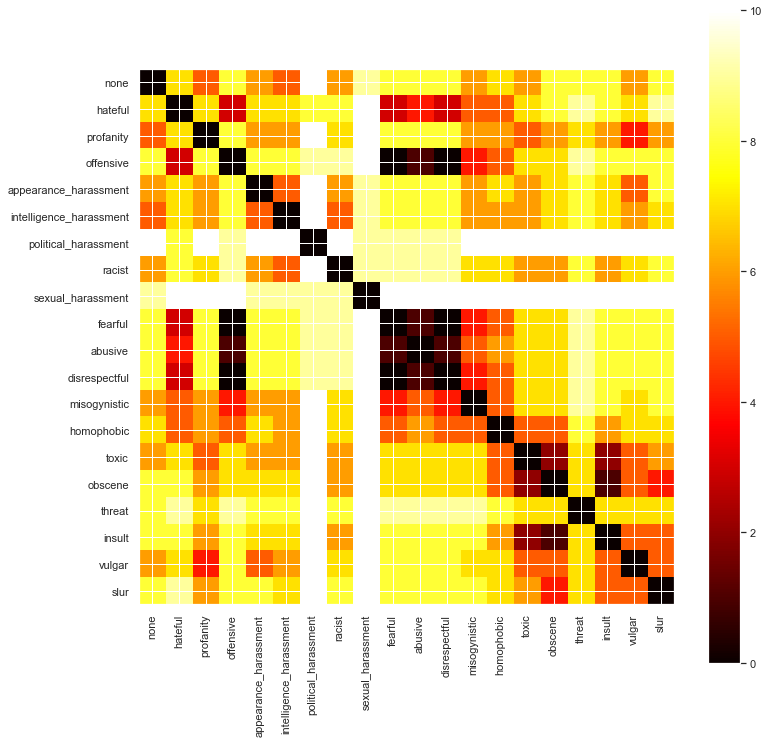

In [11]:

def distance(s1,s2):
    s1 = set(s1).intersection(s2)
    return 10 - len(list(s1))
    
n = 10
s = {}
ng_cfd = extract_ngrams(corpus,1)
ct = 0
for k in ng_cfd.keys():
    mk = ng_cfd[k].most_common(n)
    words = []
    for ng in mk:
        word = ng[0][0]
        words.append(word)
    s[ct] = words
    ct += 1
k = len(s.keys())
dist = np.zeros((k,k))
for i in range(k):
    for j in range(k):

        dist[i][j] = distance(s[i],s[j])
        dist[j][i] = distance(s[i],s[j])


plt.figure(figsize=(12,12))
plt.imshow(dist,cmap='hot',interpolation='nearest')
ax = plt.gca()
xticks = range(k)
yticks = range(k)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(list(ng_cfd.keys()), rotation = 90)
ax.set_yticklabels(list(ng_cfd.keys()))
plt.colorbar()
#hierarchy.dendrogram(Z)

plt.show()


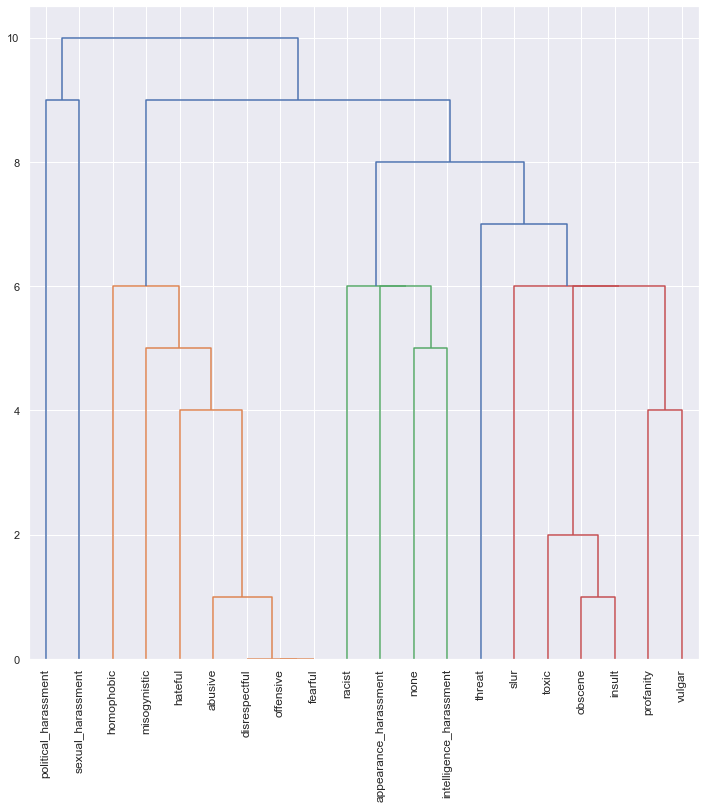

In [12]:
plt.figure(figsize=(12,12))
condensed = scipy.spatial.distance.squareform(np.array(dist))
Z = hierarchy.linkage(condensed,'complete')
hierarchy.dendrogram(Z)
ax = plt.gca()
lab = ax.get_xticklabels()
lab = [lab[i].get_text() for i in range(len(lab))]
kl = list(ng_cfd.keys())
xlabels = []
for l in lab:
    xlabels.append(kl[int(l)])
ax.set_xticklabels(xlabels, rotation = 90)
plt.show()

In [18]:
chi_square_test(corpus,unique)

Current class: none
Current class: hateful
Current class: profanity
Current class: offensive
Current class: appearance_harassment
fatass
Current class: intelligence_harassment
Current class: political_harassment
Current class: racist
Current class: sexual_harassment
camel
toe
grab
sporti
p
ssi
skullfuck
Current class: fearful
Current class: abusive
Current class: disrespectful
Current class: misogynistic
Current class: homophobic
Current class: toxic
Current class: obscene
Current class: threat
Current class: insult
Current class: vulgar
Current class: slur


[('fatass', 'appearance_harassment'),
 ('camel', 'sexual_harassment'),
 ('toe', 'sexual_harassment'),
 ('grab', 'sexual_harassment'),
 ('sporti', 'sexual_harassment'),
 ('p', 'sexual_harassment'),
 ('ssi', 'sexual_harassment'),
 ('skullfuck', 'sexual_harassment')]

### Basic neural approaches

In this part we will present basic neural approaches such as Word2Vec and plot its embedding to see the relationship between the labels

In [8]:
def extract_most_common_words(corpus,model,n):
    
    #Extracts n most common 1-grams for each label for the  corpus
    # whole_corpus has Word2Vec (or some others models) embeddings for all the words
    # Corpus_dict splits the values under the labels
    # words holds all the words
    cfd = calculate_cond_frequencies(corpus)
    whole_corpus = []
    corpus_dict = {}
    
    for k in cfd.keys():
        mc = cfd[k].most_common(n)

        vocab = []
        for w in mc:
            word = w[0]
            vocab.append(word)
            whole_corpus.append(word)
        corpus_dict[k] = model[vocab]
    
    words = whole_corpus
    whole_corpus = model[whole_corpus]
    return whole_corpus, corpus_dict, words

#Plots the embeddings decomposed by the PCA algorithm
def plot_word2vec(whole_corpus,corpus_dict, words):
    
    pca = PCA(n_components = 2)
    whole_corpus = pca.fit_transform(whole_corpus)
    
    plt.figure(1,figsize=(12,12))
    ct = 0
    ctc = 0
    cmap = plt.cm.get_cmap('Spectral')
    
    for k in corpus_dict.keys():
        
        x = pca.transform(corpus_dict[k])
        plt.scatter(x[:,0],x[:,1],color=cmap((ctc+1)/len(corpus_dict.keys())))
        x_povp = np.mean(x,axis=0)
        
        plt.scatter(x_povp[0],x_povp[1],50,color=cmap((ctc+1)/len(corpus_dict.keys())))
        plt.annotate(k,xy=(x_povp[0],x_povp[1]),size=18)
        ctc += 1
        
        for i in range(x.shape[0]):
            #plt.annotate(words[ct],xy=(x[i,0],x[i,1]))
            ct += 1
            
def plot_fast_text(keywords,model):
    X = model[keywords]
    pca = PCA(n_components=2)
    plt.figure(1,figsize=(12,12))
    X = pca.fit_transform(X)
    for i in range(X.shape[0]):
        plt.scatter(X[i,0],X[i,1])
        plt.annotate(keywords[i],xy=(X[i,0],X[i,1]))
    plt.show()
        



['none' 'hateful' 'profanity' 'offensive' 'appearance_harassment'
 'intelligence_harassment' 'political_harassment' 'racist'
 'sexual_harassment' 'fearful' 'abusive' 'disrespectful' 'misogynistic'
 'homophobic' 'toxic' 'obscene' 'threat' 'insult' 'vulgar' 'slur']


<ipython-input-8-e751b85f6d49>:51: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[keywords]


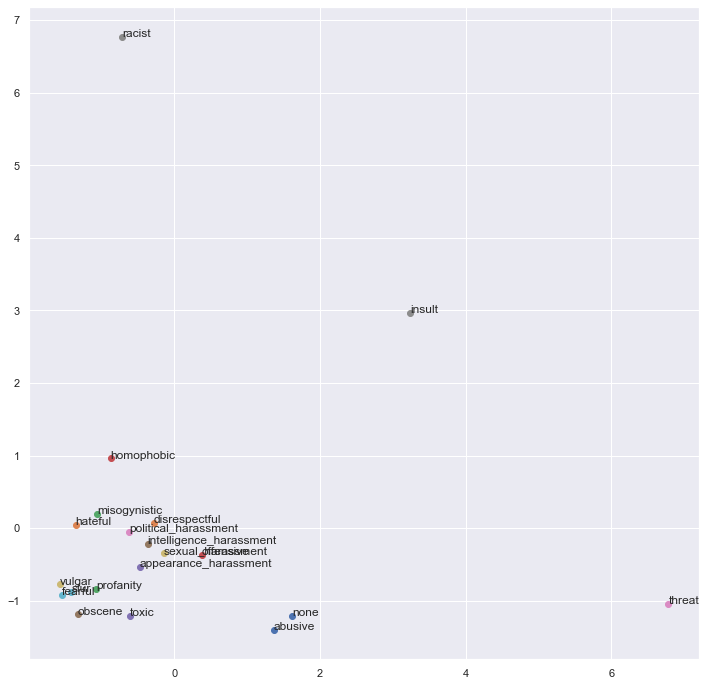

In [9]:
tokens = corpus["stemmed"].tolist()
model = gensim.models.FastText(size=20,window=3,min_count=1)
model.build_vocab(tokens)
model.train(sentences=tokens,total_examples=len(tokens),epochs=10)
keywords = np.array(list(cfd.keys()))
#keywords = np.setdiff1d(keywords,np.array(["racist","insult","threat"]))
print(keywords)
plot_fast_text(keywords,model)

<ipython-input-8-e751b85f6d49>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  corpus_dict[k] = model[vocab]
<ipython-input-8-e751b85f6d49>:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  whole_corpus = model[whole_corpus]


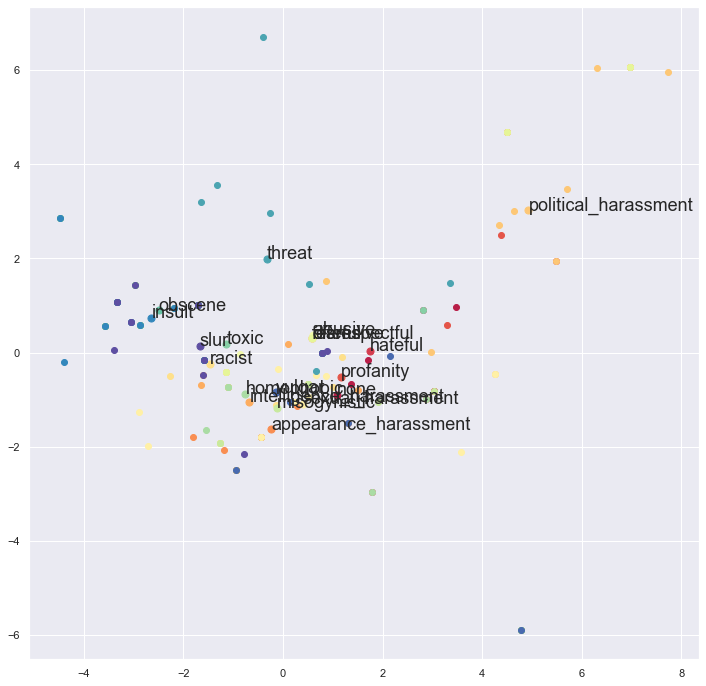

In [10]:
tokens = corpus["stemmed"].tolist()
model = gensim.models.Word2Vec(tokens,min_count=1)
whole_corpus, corpus_dict, words = extract_most_common_words(corpus,model,10)
plot_word2vec(whole_corpus,corpus_dict,words)

## Diffetent datasets with the same label exploration

In [6]:
corpus["source"] = df["source"]

In [33]:
def tokenize_and_stem(text):
    twk = nltk.tokenize.TweetTokenizer()
    stemmer = SnowballStemmer("english")
    
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token.
    tokens = [word for sent in nltk.sent_tokenize(text) for word in twk.tokenize(sent)]
    #tokens = [word for word in twk.tokenize(text)]
    
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation).
    for token in tokens:
        if re.search('[a-zA-Z]', token) and not ("@" in token or "http" in token or "t.co" in token or "#" in token  or "<" in token): #or '\\u' in token
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens] # .replace('\\','')
    return stems



### Hateful label

In [11]:
hateful_corpus = corpus[corpus["sentiment"] == "hateful"]
n = 10
s = {}
for i in range(1,4):
    ng_cfd = extract_ngrams(hateful_corpus,i,label="source")
    for k in ng_cfd.keys():
        print(f"{n} most common {i}-grams for {k}: {ng_cfd[k].most_common(n)}")
        
    print("===========================================================")

10 most common 1-grams for 25_twitter: [(('peopl',), 99), (('muslim',), 96), (('trump',), 91), (('like',), 89), (('world',), 84), (('doctor',), 83), (('get',), 80), (('icc',), 71), (('countri',), 70), (('say',), 67)]
10 most common 1-grams for 20_twitter: [(('retard',), 262), (('faggot',), 165), (('countri',), 150), (('fuck',), 137), (('shithol',), 131), (('cunt',), 110), (('like',), 93), (('chong',), 88), (('ching',), 86), (('twat',), 85)]
10 most common 2-grams for 25_twitter: [(('world', 'cup'), 45), (('bori', 'johnson'), 18), (('dhoni', 'glove'), 17), (('west', 'bengal'), 13), (('look', 'like'), 12), (('mamata', 'banerje'), 11), (('lock', 'lock'), 10), (('rain', 'england'), 9), (('cricket', 'fan'), 9), (('cricket', 'council'), 8)]
10 most common 2-grams for 20_twitter: [(('shithol', 'countri'), 96), (('ching', 'chong'), 84), (('illeg', 'alien'), 30), (('fuck', 'retard'), 26), (('go', 'back'), 21), (('look', 'like'), 14), (('back', 'countri'), 13), (('call', 'faggot'), 12), (('peopl

In [13]:
chi_square_test(hateful_corpus,[],label="source")

Current class: 25_twitter
Current class: 20_twitter


[]

In [20]:
corpus_join_source = hateful_corpus.groupby(['source'])['text'].apply(lambda x: '. '.join(x)).reset_index()
corpus_join_source

,source,text
0,20_twitter,@user Que ce ne soit pas des Burundais refugie...
1,25_twitter,@politico No. We should remember very clearly ...


In [34]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
train = True
if train:
    # Define vectorizer parameters
    tfidf_vectorizer = TfidfVectorizer(
                            max_df=0.8, 
                            max_features=200000,
                            min_df=0.2, 
                            stop_words='english', 
                            use_idf=True, 
                            tokenizer=tokenize_and_stem, 
                            ngram_range=(1,1))
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_join_source.text.to_list())
    print("TF-IDF matrix shape: {}".format(tfidf_matrix.shape))
    with open('tfidf_vectorizer_and_matrix_hateful.pickle','wb') as file:
        pickle.dump((tfidf_vectorizer,tfidf_matrix),file)
else:
    with open('tfidf_vectorizer_and_matrix_hateful.pickle','rb') as file:
        (tfidf_vectorizer,tfidf_matrix) = pickle.load(file)

C:\Users\MaticF\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TF-IDF matrix shape: (2, 4171)


In [37]:
feature_names = tfidf_vectorizer.get_feature_names()
#print(tfidf_matrix.shape)
indices = np.argsort(tfidf_matrix.todense(),axis=1)
for i in range(len(corpus_join_source)):
    print(corpus_join_source.source[i] )
    for j in range(1,10):
        print('\t',feature_names[indices[i,-j]],tfidf_matrix[i,indices[i,-j]])

20_twitter
	 retard 0.6601423204223511
	 faggot 0.41573848423545007
	 shithol 0.33007116021117555
	 chong 0.22172719159224005
	 ching 0.21668793723787097
	 twat 0.21416831006068643
	 nigger 0.18645241111165642
	 spic 0.17637390240291823
	 mongoloid 0.1310206132135964
25_twitter
	 doctor 0.3556112459547704
	 icc 0.30419757184082763
	 cricket 0.27420626194102776
	 rain 0.2399304791983993
	 glove 0.2356460063555707
	 cup 0.2056546964557708
	 india 0.20137022361294224
	 bori 0.1542410223418281
	 ground 0.14995654949899956


### Offensive label

In [15]:
offensive_corpus = corpus[corpus["sentiment"] == "offensive"]
n = 10
s = {}
for i in range(1,4):
    ng_cfd = extract_ngrams(offensive_corpus,i,label="source")
    for k in ng_cfd.keys():
        print(f"{n} most common {i}-grams for {k}: {ng_cfd[k].most_common(n)}")
        
    print("===========================================================")

10 most common 1-grams for 25_twitter: [(('trump',), 82), (('get',), 42), (('peopl',), 38), (('lie',), 35), (('countri',), 34), (('traitor',), 34), (('one',), 30), (('like',), 29), (('presid',), 29), (('u',), 29)]
10 most common 1-grams for 20_twitter: [(('retard',), 963), (('faggot',), 390), (('countri',), 372), (('fuck',), 363), (('cunt',), 361), (('shithol',), 344), (('twat',), 317), (('like',), 302), (('ching',), 289), (('chong',), 283)]
10 most common 2-grams for 25_twitter: [(('cough', 'cough'), 14), (('white', 'hous'), 8), (('treason', 'traitor'), 6), (('father', 'day'), 6), (('sexual', 'predat'), 5), (('get', 'even'), 5), (('happi', 'father'), 4), (('win', 'elect'), 4), (('unit', 'state'), 4), (('piec', 'shit'), 4)]
10 most common 2-grams for 20_twitter: [(('ching', 'chong'), 277), (('shithol', 'countri'), 241), (('fuck', 'retard'), 74), (('illeg', 'alien'), 60), (('n', 'n'), 45), (('full', 'retard'), 39), (('look', 'like'), 39), (('go', 'back'), 35), (('okay', 'white'), 34), (

In [16]:
chi_square_test(offensive_corpus,[],label="source")

Current class: 25_twitter
Current class: 20_twitter


[]

In [38]:
corpus_join_source = offensive_corpus.groupby(['source'])['text'].apply(lambda x: '. '.join(x)).reset_index()
corpus_join_source

,source,text
0,20_twitter,Most Canadians have never met seen or associat...
1,25_twitter,@TheRealOJ32 The world will rejoice when you d...


In [39]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
train = True
if train:
    # Define vectorizer parameters
    tfidf_vectorizer = TfidfVectorizer(
                            max_df=0.8, 
                            max_features=200000,
                            min_df=0.2, 
                            stop_words='english', 
                            use_idf=True, 
                            tokenizer=tokenize_and_stem, 
                            ngram_range=(1,1))
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_join_source.text.to_list())
    print("TF-IDF matrix shape: {}".format(tfidf_matrix.shape))
    with open('tfidf_vectorizer_and_matrix_offensive.pickle','wb') as file:
        pickle.dump((tfidf_vectorizer,tfidf_matrix),file)
else:
    with open('tfidf_vectorizer_and_matrix_offensive.pickle','rb') as file:
        (tfidf_vectorizer,tfidf_matrix) = pickle.load(file)

C:\Users\MaticF\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TF-IDF matrix shape: (2, 5469)


In [40]:
feature_names = tfidf_vectorizer.get_feature_names()
#print(tfidf_matrix.shape)
indices = np.argsort(tfidf_matrix.todense(),axis=1)
for i in range(len(corpus_join_source)):
    print(corpus_join_source.source[i] )
    for j in range(1,10):
        print('\t',feature_names[indices[i,-j]],tfidf_matrix[i,indices[i,-j]])

20_twitter
	 retard 0.7180221893560964
	 faggot 0.2907878025429674
	 cunt 0.2691651197897724
	 shithol 0.2564897540378995
	 twat 0.2363582907849248
	 ching 0.21548121778183993
	 chong 0.21100755928117892
	 spic 0.1461395110215939
	 nigger 0.1431570720211532
25_twitter
	 traitor 0.5587300905353787
	 mamata 0.19719885548307484
	 treason 0.19719885548307484
	 doctor 0.19719885548307484
	 icc 0.18076561752615194
	 impeach 0.14789914161230613
	 incompet 0.11503266569846034
	 halala 0.09859942774153742
	 coward 0.09859942774153742


### Political harassment

In [17]:
pol_corpus = corpus[corpus["sentiment"] == "political_harassment"]
n = 10
s = {}
for i in range(1,4):
    ng_cfd = extract_ngrams(pol_corpus,i,label="source")
    for k in ng_cfd.keys():
        print(f"{n} most common {i}-grams for {k}: {ng_cfd[k].most_common(n)}")
        
    print("===========================================================")

10 most common 1-grams for 32_twitter: [(('twatwaffl',), 217), (('fuck',), 121), (('rt',), 103), (('trump',), 92), (('fuckbag',), 84), (('like',), 54), (('dickwad',), 51), (('get',), 50), (('ass',), 48), (('douch',), 46)]
10 most common 1-grams for 16_facebook: [(('muslim',), 2846), (('islam',), 1537), (('countri',), 536), (('religion',), 438), (('rape',), 413), (('peopl',), 384), (('want',), 367), (('us',), 319), (('women',), 316), (('cultur',), 310)]
10 most common 2-grams for 32_twitter: [(('dumb', 'fuck'), 26), (('douch', 'bag'), 17), (('baggi', 'twatwaffl'), 12), (('dumb', 'ass'), 8), (('get', 'head'), 8), (('u', 'want'), 8), (('liber', 'twatwaffl'), 8), (('would', 'rather'), 8), (('twatwaffl', 'like'), 8), (('twatwaffl', 'stop'), 8)]
10 most common 2-grams for 16_facebook: [(('rape', 'children'), 121), (('western', 'societi'), 115), (('islam', 'muslim'), 97), (('muslim', 'countri'), 77), (('islam', 'cult'), 76), (('contribut', 'societi'), 72), (('muslim', 'noth'), 72), (('civilis

In [18]:
chi_square_test(pol_corpus,[],label="source")

Current class: 32_twitter
Current class: 16_facebook


[]

In [41]:
corpus_join_source = pol_corpus.groupby(['source'])['text'].apply(lambda x: '. '.join(x)).reset_index()
corpus_join_source

,source,text
0,16_facebook,"According to a recent OFSTED report, a school ..."
1,32_twitter,.@realdonaldtrump hey fucktard remember when...


In [42]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
train = True
if train:
    # Define vectorizer parameters
    tfidf_vectorizer = TfidfVectorizer(
                            max_df=0.8, 
                            max_features=200000,
                            min_df=0.2, 
                            stop_words='english', 
                            use_idf=True, 
                            tokenizer=tokenize_and_stem, 
                            ngram_range=(1,1))
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_join_source.text.to_list())
    print("TF-IDF matrix shape: {}".format(tfidf_matrix.shape))
    with open('tfidf_vectorizer_and_matrix_pol.pickle','wb') as file:
        pickle.dump((tfidf_vectorizer,tfidf_matrix),file)
else:
    with open('tfidf_vectorizer_and_matrix_pol.pickle','rb') as file:
        (tfidf_vectorizer,tfidf_matrix) = pickle.load(file)

C:\Users\MaticF\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TF-IDF matrix shape: (2, 1565)


In [43]:
feature_names = tfidf_vectorizer.get_feature_names()
#print(tfidf_matrix.shape)
indices = np.argsort(tfidf_matrix.todense(),axis=1)
for i in range(len(corpus_join_source)):
    print(corpus_join_source.source[i] )
    for j in range(1,10):
        print('\t',feature_names[indices[i,-j]],tfidf_matrix[i,indices[i,-j]])

16_facebook
	 islam 0.8260004681447686
	 religion 0.2353859499332522
	 cultur 0.16659736182490453
	 violenc 0.15154985817620348
	 cult 0.11070663398687204
	 koran 0.0940468978043816
	 western 0.09297207611518866
	 europ 0.08706055682462753
	 problem 0.0859857351354346
32_twitter
	 twatwaffl 0.6724521293946226
	 rt 0.31918234713200977
	 trump 0.28509491200140685
	 fuckbag 0.260304050088241
	 you'r 0.2014257530444722
	 dickwad 0.15804174469643203
	 ass 0.14874517147899485
	 douch 0.14254745600070343
	 shit 0.09296573217437179
